In [3]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import fasttext
import torch
import matplotlib.pyplot as plt

c:\Users\Laura\anaconda3\envs\arh_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Pasul 1: Adunarea Datelor
- Am tradus listele originale ale testului WEAT în limba română
- Am colectat listele culturale CA-WEAT de la vorbitorii nativi de limba română pentru a reflecta particularitățile culturale

*Am avut grijă ca toate cuvintele vorbitorilor să fie uzuale, bine definite și să apară cât mai frecvent în corpusurile de antrenare (i.e. modelele folosite pentru embedding-uri și analiză)*

Am observat încă din timpul traducerii testului original WEAT faptul că acesta nu poate fi adaptat în totalitate cerințelor și contextelor limbii române întrucât cuvinte ca wasp, hornet se traduc în română ca fiind viespe, sau horn care în română are multiple sensuri (atât de corn - instrument muzical, cât și corn - aliment). De asemenea, cuvinte ca gun, pistol, rifle, shotgun se traduc în română ca pistol/pușcă. Acest lucru a scurtat considerabil lista de elemente target, ceea ce face ne face deja să bănuim că lista WEAT originală, adaptată în limba română nu poate reflecta cu adevărat biasurile culturale specifice limbii.


In [4]:
file_weat_list = "data/weat_list.tsv"
df_weat_list = pd.read_csv(file_weat_list, sep="\t", index_col=False, header=None)
df_weat_list.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,Flori,aster,trifoi,zambilă,gălbenele,mac,azalee,șofran,iris,orhidee,...,păpădie,margaretă,crin,bujor,violetă,garoafă,gladiolă,magnolie,petunie,zinia
1,Insecte,furnică,omidă,purice,lăcustă,păianjen,ploșniță,chilopod,muscă,vierme,...,greiere,gărgăun,molie,viespe,muscă,libelulă,tăun,căpușă,NaN,NaN
2,Instrumente Muzicale,cimpoi,violoncel,chitară,lăută,trombon,banjo,clarinet,muzicuță,mandolină,...,clopot,vioară,clavecin,pian,violă,bongos,fluier,corn,saxofon,xilofon
3,Arme,săgeată,bâtă,pușcă,rachetă,suliță,topor,pumnal,harpon,pistol,...,armă,cuțit,pușcă,gaz lacrimogen,tun,grenadă,buzdugan,praștie,bici,NaN
4,Plăcut,mângâiere,libertate,sănătate,iubire,pace,veselie,prieten,rai,loial,...,diplomă,cadou,onoare,miracol,răsărit,familie,fericit,râs,paradis,vacanță


In [21]:
# Procesăm datele din lista WEAT
clean_weat_list={}

for index, row in df_weat_list.iterrows():
    category = row[0]  # Prima coloană este categoria
    words = set(row[1:].dropna())  # Restul elementelor formează mulțimea, eliminăm valorile NaN
    clean_weat_list[category] = words

# Afișează mulțimile
for category, word_set in clean_weat_list.items():
    print(f"{category}: {word_set}\n")
    

print("Structura de date a listei WEAT: \n")
print(clean_weat_list)

Flori: {'clopoțel', 'panseluță', 'azalee', 'trandafir', 'zinia', 'liliac', 'mac', 'petunie', 'magnolie', 'gladiolă', 'păpădie', 'lalea', 'bujor', 'margaretă', 'trifoi', 'crin', 'zambilă', 'violetă', 'gălbenele', 'garoafă', 'orhidee', 'iris', 'șofran', 'aster', 'narcisă'}

Insecte: {'tarantulă', 'greiere', 'păianjen', 'termite', 'molie', 'căpușă', 'muscă', 'tăun', 'viespe', 'omidă', 'furnică', 'albină', 'țânțar', 'gărgăun', 'libelulă', 'gândac', 'chilopod', 'musculiță', 'vierme', 'purice', 'lăcustă', 'ploșniță'}

Instrumente Muzicale: {'violă', 'mandolină', 'saxofon', 'oboi', 'bongos', 'violoncel', 'tubă', 'xilofon', 'chitară', 'muzicuță', 'trompetă', 'clarinet', 'pian', 'tobă', 'corn', 'clavecin', 'harpă', 'trombon', 'lăută', 'clopot', 'fagot', 'fluier', 'vioară', 'cimpoi', 'banjo'}

Arme: {'sabie', 'gaz lacrimogen', 'praștie', 'pistol', 'buzdugan', 'secure', 'pușcă', 'suliță', 'armă', 'harpon', 'pumnal', 'săgeată', 'topor', 'dinamită', 'rachetă', 'bici', 'cuțit', 'lamă', 'bombă', 'tun

In [6]:
# Procesăm datele din răspunsurile la Google Forms pentru listele CAWEAT ale participanților români

file_ca_weat = "data/responses.csv"

df_ca_weat_list = pd.read_csv(file_ca_weat)

# Redenumirea coloanelor pentru acces mai ușor
df_ca_weat_list.columns = ["timestamp", "fruits", "weapons", "flowers", "instruments", "insects", "pleasant", "unpleasant"]

df_ca_weat_list.drop(columns=["timestamp"], inplace=True)

df_ca_weat_list.head()


,fruits,weapons,flowers,instruments,insects,pleasant,unpleasant
0,"mar, banana, pere, caise, struguri, gutuie, ci...","pistol, revolver, mitralieră, cutit, pușcă cu ...","trandafir, lalea, crin, margaretă, ghiocel, za...","chitară, pian, vioară, trompetă, saxofon, tobe...","furnică, albină, viespe, țânțar, muscă, libelu...","iubire, armonie, liniște, libertate, fericire,...","ură, frică, tristețe, stres, singurătate, anxi..."
1,"măr, pară, banană, portocală, prună, caisă, pi...","sabie, suliță, arc, cuțit, pumnal, topor, buzd...","albăstrea, floarea soarelui, zambilă, ghiocel,...","acordeon, buhai, chitară, clarinet, clopot, co...","allbină, bondar, buburuză, căpușă, cărăbuș, ci...","floare, câmp, parc, curcubeu, frumos, distract...","ploaie, vânt, ură, ceartă, ceață, furtună, vij..."
2,"măr, pară, cireașă, vișină, banană, kiwi, zmeu...","cuțit, pumnal, pistol, sabie, pușcă, topor, br...","trandafir, floarea soarelui, lalele, lavanda, ...","violă, vioară, violoncel, contrabas, chitară, ...","țânțar, greier, muscă, albină, bondar, viespe,...","cafea, muzică, floarea soarelui, barca, fotbal...","mov, pești, moarte, război, abandon, boală, su..."
3,"mere,pere,banane,zmeura,capsuni,portocale,mand...","pistol,ciocan,baltag,mitraliera,pumnal,sabie,p...","trandafir,bujor,lalea,margareta,gura leului,ga...","pian,trompeta,vioara,violoncel,tuba,tobe,nai,f...","carabus,albina,gargarita,furnica,viespe,musca,...","soare,natura,caldura,plaja,nisip,valuri,linist...","frig,mizerie,saracie,prostie,foamete,razboi,je..."
4,"mere, pere, struguri, mure, zmeură, căpșune, c...","pistol, mitralieră, cuțit, bombă, grenadă, top...","narcisă, crizantemă, mac, trandafir, lalea, fr...","acordeon, chitară, violoncel, vioară, pian, xi...","fluture, gărgărițe, păianjeni, muște, țânțari,...","soare, vară, plajă, iubire, familie, acasă, că...","boală, moarte, accident, cancer, explozie, răz..."


In [8]:
# Procesarea răspunsurilor într-un dicționar curățat și transformat în seturi, cu numerotare
ca_weat_responses_cleaned = {}

for idx, row in df_ca_weat_list.iterrows():
    user_id = f"User_{idx + 1}"  # Numerotare consecutivă începând de la 1
    ca_weat_responses_cleaned[user_id] = {
        "fruits": set(item.strip() for item in row["fruits"].split(",") if item.strip()),
        "weapons": set(item.strip() for item in row["weapons"].split(",") if item.strip()),
        "flowers": set(item.strip() for item in row["flowers"].split(",") if item.strip()),
        "instruments": set(item.strip() for item in row["instruments"].split(",") if item.strip()),
        "insects": set(item.strip() for item in row["insects"].split(",") if item.strip()),
        "pleasant": set(item.strip() for item in row["pleasant"].split(",") if item.strip()),
        "unpleasant": set(item.strip() for item in row["unpleasant"].split(",") if item.strip()),
    }

# Afișează rezultatele pentru verificare
for user_id, responses in ca_weat_responses_cleaned.items():
    print(f"{user_id}:")
    for category, items in responses.items():
        print(f"  {category}: {items}")
    print()

print(ca_weat_responses_cleaned)

User_1:
  fruits: {'coacaze', 'caise', 'visine', 'pere', 'mandarina', 'capsuna', 'pepene galben', 'cocos', 'rodie', 'grapefruit', 'portocala', 'gutuie', 'lychee', 'mar', 'papaya', 'cirese', 'ananas', 'kiwi', 'piersica', 'zmeura', 'mango', 'pepene rosu', 'banana', 'struguri', 'fructul pasiunii'}
  weapons: {'arc', 'băț', 'mitralieră', 'pușcă cu lunetă', 'arbaletă', 'revolver', 'cutit', 'pistol', 'lansator de rachete', 'baston', 'topor', 'shotgun', 'cuțit', 'grenadă', 'chakram', 'floretă', 'tun', 'katana', 'sabie', 'muschetă', 'macetă', 'suliță', 'buzdugan', 'shuriken', 'pumnal'}
  flowers: {'orhidee', 'frezie', 'zambilă', 'narcisa', 'violete', 'lavandă', 'panseluță', 'trandafir', 'crin', 'petunie', 'dalii', 'floare de colț', 'iris', 'camelia', 'floare de nu ma uita', 'liliac', 'garoafă', 'margaretă', 'begonie', 'lalea', 'ghiocel', 'floarea-soarelui', 'iasomie', 'hortensie', 'bujor'}
  instruments: {'banjo', 'vioară', 'trompetă', 'harpă', 'ukulele', 'acordeon', 'mandolină', 'cimpoi', 'co

In [24]:
nr_useri = len(ca_weat_responses_cleaned)
print(nr_useri)

10


# Pasul 2: Definirea modelelor pentru analiza statistică 

- **FastText**: vom folosi modelul **cc.ro.300** care este un **model monolingual**, fiind antrenat exclusiv pe corpusuri de text în limba română.    


- **mBERT (Monolingual BERT)**: **Model multilingv avansat, bazat pe arhitectura Transformer**, antrenat pe mai multe limbi, inclusiv limba română. Embedding-urile generate de mBERT sunt contextuale, ceea ce înseamnă că semnificația unui cuvânt este influențată de contextul în care apare în propoziție. Acesta permite analiza contextului în propoziții, fiind utilă pentru evaluarea semantică. 


- **XLM-R (Cross-lingual RoBERTa)**: **Model multilingv avansat, bazat pe arhitectura Transformer**, antrenat pe mai multe limbi, inclusiv limba română. XLM-R oferă embedding-uri mai robuste pentru sarcini multilingve și cross-linguale, fiind o versiune îmbunătățită a mBERT. La fel ca BERT, XLM-R generează embedding-uri care depind de contextul în care este utilizat cuvântul.



In [13]:
# Configurare modele
FASTTEXT_MODEL_PATH = "cc.ro.300.bin"  
MBERT_MODEL_NAME = "bert-base-multilingual-cased"
XLMR_MODEL_NAME = "xlm-roberta-base"

# Încarcă tokenizer și modele HuggingFace
mbert_tokenizer = AutoTokenizer.from_pretrained(MBERT_MODEL_NAME)
mbert_model = AutoModel.from_pretrained(MBERT_MODEL_NAME)

xlmr_tokenizer = AutoTokenizer.from_pretrained(XLMR_MODEL_NAME)
xlmr_model = AutoModel.from_pretrained(XLMR_MODEL_NAME)

fasttext_model = fasttext.load_model(FASTTEXT_MODEL_PATH)


### Calcularea embedding-urilor pentru WEAT și CA-WEAT folosind modelul FastText 

In [ ]:
# Funcție pentru obținerea embedding-urilor pentru WEAT
def process_weat(weat_data, model):
    weat_embeddings = {}
    for category, words in weat_data.items():
        embeddings = [model.get_word_vector(word) for word in words]
        weat_embeddings[category] = embeddings
    return weat_embeddings

# Apel pentru FastText
weat_embeddings_fasttext = process_weat(clean_weat_list, fasttext_model)
print(weat_embeddings_fasttext)


In [ ]:
# Funcție pentru obținerea embedding-urilor pentru CA-WEAT
def process_ca_weat(ca_weat_data, model):
    ca_weat_embeddings = {}
    for user, categories in ca_weat_data.items():
        user_embeddings = {}
        for category, words in categories.items():
            embeddings = [model.get_word_vector(word) for word in words]
            user_embeddings[category] = embeddings
        ca_weat_embeddings[user] = user_embeddings
    return ca_weat_embeddings

# Apel pentru FastText
ca_weat_embeddings_fasttext = process_ca_weat(ca_weat_responses_cleaned, fasttext_model)
print(ca_weat_embeddings_fasttext)


### Calcularea embedding-urilor pentru WEAT și CA-WEAT folosind modelul mBERT 

In [ ]:
# Funcție pentru obținerea embedding-urilor mBERT pentru WEAT
def process_weat_mbert(weat_data, tokenizer, model):
    weat_embeddings = {}
    for category, words in weat_data.items():
        embeddings = []
        for word in words:
            inputs = tokenizer(word, return_tensors="pt")
            outputs = model(**inputs)
            # Extragem embedding-ul pentru al doilea token (cuvântul efectiv)
            embedding = outputs.last_hidden_state[0][1].detach().numpy()
            embeddings.append(embedding)
        weat_embeddings[category] = embeddings
    return weat_embeddings

# Exemplu utilizare pentru mBERT
weat_embeddings_mbert = process_weat_mbert(clean_weat_list, mbert_tokenizer, mbert_model)
print(weat_embeddings_mbert)

In [ ]:
# Funcție pentru obținerea embedding-urilor mBERT pentru CA-WEAT
def process_ca_weat_mbert(ca_weat_data, tokenizer, model):
    ca_weat_embeddings = {}
    for user, categories in ca_weat_data.items():
        user_embeddings = {}
        for category, words in categories.items():
            embeddings = []
            for word in words:
                inputs = tokenizer(word, return_tensors="pt")
                outputs = model(**inputs)
                # Extragem embedding-ul pentru al doilea token
                embedding = outputs.last_hidden_state[0][1].detach().numpy()
                embeddings.append(embedding)
            user_embeddings[category] = embeddings
        ca_weat_embeddings[user] = user_embeddings
    return ca_weat_embeddings

ca_weat_embeddings_mbert = process_ca_weat_mbert(ca_weat_responses_cleaned, mbert_tokenizer, mbert_model)
print(ca_weat_embeddings_mbert)

### Calcularea embedding-urilor pentru WEAT și CA-WEAT folosind modelul XLM-R 

In [ ]:
# Funcție pentru obținerea embedding-urilor XLM-R pentru WEAT
def process_weat_xlmr(weat_data, tokenizer, model):
    weat_embeddings = {}
    for category, words in weat_data.items():
        embeddings = []
        for word in words:
            inputs = tokenizer(word, return_tensors="pt")
            outputs = model(**inputs)
            # Extragem embedding-ul pentru al doilea token (cuvântul efectiv)
            embedding = outputs.last_hidden_state[0][1].detach().numpy()
            embeddings.append(embedding)
        weat_embeddings[category] = embeddings
    return weat_embeddings

weat_embeddings_xlmr = process_weat_xlmr(clean_weat_list, xlmr_tokenizer, xlmr_model)
print(weat_embeddings_xlmr)


In [ ]:
# Funcție pentru obținerea embedding-urilor XLM-R pentru CA-WEAT
def process_ca_weat_xlmr(ca_weat_data, tokenizer, model):
    ca_weat_embeddings = {}
    for user, categories in ca_weat_data.items():
        user_embeddings = {}
        for category, words in categories.items():
            embeddings = []
            for word in words:
                inputs = tokenizer(word, return_tensors="pt")
                outputs = model(**inputs)
                # Extragem embedding-ul pentru al doilea token
                # Pentru transformere, tokenizarea implică adăugarea unui token special la începutul secvenței
                embedding = outputs.last_hidden_state[0][1].detach().numpy()
                embeddings.append(embedding)
            user_embeddings[category] = embeddings
        ca_weat_embeddings[user] = user_embeddings
    return ca_weat_embeddings

ca_weat_embeddings_xlmr = process_ca_weat_xlmr(ca_weat_responses_cleaned, xlmr_tokenizer, xlmr_model)
print(ca_weat_embeddings_xlmr)

# Pasul 3: Definirea funcțiilor pentru analiza statistică

## 1. Similaritatea cosinus
Formula pentru măsurarea similarității dintre doi vectori:
${
sim(t, a) = 1 - \text{cosine}(t, a)
}$


In [28]:
# Similaritate cosinus
from scipy.spatial.distance import cosine

def cosine_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

## 2. Calculul asocierii unui cuvânt cu o categorie:

Măsoară cât de bine un cuvânt țintă ${t}$ este asociat cu o categorie ${A}$ . Calculează media similarităților cosinus dintre vectorul cuvântului și vectorii tuturor elementelor din categoria ${A}$.  
Asocierile permit măsurarea gradului de relaționare între un concept și o categorie semantică.

${assoc(t, A) = \frac{\sum_{a \in A} sim(t, a)}{|A|}}$

In [29]:
# Calculul asocierii unui vector țintă cu o categorie
def calculate_assoc(target_vec, category_vectors):
    if not category_vectors:  # Verifică dacă lista este goală
        return 0.0
    similarities = [cosine_similarity(target_vec, vec) for vec in category_vectors]
    return np.mean(similarities)

## 3. Diferența de asociere dintre două categorii

Compară asocierea unui cuvânt țintă ${t}$ cu două categorii  ${A}$ și ${B}$.
Diferența între valorile asocierilor indică în ce măsură ${t}$ este mai aporpiat semantic de ${A}$ decât de ${B}$.  
Astfel verificăm dacă termeni din lista flori/insecte sunt mai apropiați semnatic de lista plăcut/neplăcut.
Permite evaluarea preferinței semnatice a unui concept între două categorii.  



${\Delta assoc(t, A, B) = assoc(t, A) - assoc(t, B)}$

In [30]:
# Diferența de asociere
def calculate_delta_assoc(target_vec, category_a_vectors, category_b_vectors):
    assoc_a = calculate_assoc(target_vec, category_a_vectors)
    assoc_b = calculate_assoc(target_vec, category_b_vectors)
    return assoc_a - assoc_b

## 4. Formula statisticii s

Măsoară diferența medie dintre asocierile a două seturi țintă ( ${𝑋}$ și ${𝑌}$) cu două categorii asociate (${𝐴}$ și ${𝐵}$).  
Compară similaritatea semantică a două grupuri de cuvinte (e.g., flori vs. insecte).  
Statistica ${s}$ sintetizează diferența de asociere pe întreg setul de termeni.  


${
s = \frac{1}{n} \sum_{x \in X} \left( assoc(x, A) - assoc(x, B) \right) - \frac{1}{n} \sum_{y \in Y} \left( assoc(y, A) - assoc(y, B) \right)
}$

${
assoc(t, A) = \frac{\sum_{a \in A} sim(t, a)}{|A|}
}$

Unde:
\begin{align*}
X, Y &\text{ sunt seturile țintă (e.g., „flori” și „insecte”)} \\
A, B &\text{ sunt categoriile asociate (e.g., „plăcut” și „neplăcut”)} \\
sim(t, a) &= 1 - \text{cosine}(t, a) \\
n &= \text{numărul de elemente din } X \text{ sau } Y
\end{align*}

In [31]:
# Calculul statisticii s conform paperului
def calculate_statistic_s(target_x, target_y, category_a, category_b):
    if not target_x or not target_y or not category_a or not category_b:
        return 0.0  # Fallback pentru date invalide
    # Diferențe de asociere pentru X
    delta_assoc_x = [calculate_assoc(vec, category_a) - calculate_assoc(vec, category_b) for vec in target_x]
    # Diferențe de asociere pentru Y
    delta_assoc_y = [calculate_assoc(vec, category_a) - calculate_assoc(vec, category_b) for vec in target_y]
    # Calculul statisticii s
    statistic_s = np.mean(delta_assoc_x) - np.mean(delta_assoc_y)
    return statistic_s

## 5. Mărimea efectului ${d}$ - Cohen's ${d}$

Mărimea efectului ${d}$ este o măsură standardizată a magnitudinii biasului, definită ca diferența dintre cele două medii împărțită la deviația standard a tuturor instanțelor din ${X}$ și ${Y}$.

${
d = \frac{\mu (\Delta assoc(x, A, B) \; \forall \; x \in X) - \mu (\Delta assoc(y, A, B) \; \forall \; y \in Y)}{\sigma (\Delta assoc(w, A, B) \; \forall \; w \in X \cup Y)}
}$

#### Scara magnitudinii pentru ${d}$:
- Foarte mică: ${d < 0.01}$
- Mică: ${d < 0.20}$
- Mediu: ${d < 0.50}$
- Mare: ${d < 0.80}$
- Foarte mare: ${d < 1.20}$
- Imensă: ${d \geq 2.00}$


In [32]:
# Calculul mărimii efectului conform paperului
def calculate_effect_size(delta_assoc_x, delta_assoc_y):
    # Media pentru X și Y
    mean_x = np.mean(delta_assoc_x)
    mean_y = np.mean(delta_assoc_y)
    # Deviația standard pentru uniunea X și Y
    pooled_std = np.std(delta_assoc_x + delta_assoc_y, ddof=1)
    if pooled_std == 0:
        return 0.0  # Fallback pentru evita divizia la zero
    # Calculul mărimii efectului
    effect_size = (mean_x - mean_y) / pooled_std
    return effect_size


## 6. Bootstrap pentru intervale de încredere

Boostrap este utilizat pentru a estima robustețea rezultatelor prin generarea de monstre sintetice.
${
CI = \left[ P_{lower}, P_{upper} \right]
}$

unde:

\begin{align*}
P_{lower} &= \text{percentila inferioară (ex: 2.5\% pentru CI 95\%)} \\
P_{upper} &= \text{percentila superioară (ex: 97.5\% pentru CI 95\%)}
\end{align*}

In [33]:
# Bootstrap pentru intervale de încredere
def bootstrap_confidence_interval(data, num_samples=5000, confidence_level=0.95):
    if not data:  # Verifică dacă lista este goală
        return 0.0, 0.0
    bootstrapped_means = []
    n = len(data)
    for _ in range(num_samples):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + confidence_level) / 2 * 100)
    return lower_bound, upper_bound


In [ ]:
for categ, data in ca_weat_embeddings_fasttext.items():
    print(f"User: {categ}")
    for category, embeddings in data.items():
        print(f"  {category}: {len(embeddings)} embeddings")
    print()

In [ ]:
for category, data in weat_embeddings_fasttext.items():
    print(f"{category}: {len(data)} embeddings")

### WEAT1 pentru embedding-uri FastText

In [36]:
# Datele pentru WEAT1 pentru FastText
flowers_vectors_weat1_fasttext = weat_embeddings_fasttext["Flori"]
insects_vectors_weat1_fasttext = weat_embeddings_fasttext["Insecte"]
pleasant_vectors_weat1_fasttext = weat_embeddings_fasttext["Plăcut"]
unpleasant_vectors_weat1_fasttext = weat_embeddings_fasttext["Neplăcut"]

# Calculul diferențelor de asociere
delta_assoc_pleasant_weat1_fasttext = [
    calculate_delta_assoc(vec, pleasant_vectors_weat1_fasttext, unpleasant_vectors_weat1_fasttext)
    for vec in flowers_vectors_weat1_fasttext
]
delta_assoc_unpleasant_weat1_fasttext = [
    calculate_delta_assoc(vec, pleasant_vectors_weat1_fasttext, unpleasant_vectors_weat1_fasttext)
    for vec in insects_vectors_weat1_fasttext
]

# Calculul statisticii s
statistic_s_weat1_fasttext = calculate_statistic_s(
    flowers_vectors_weat1_fasttext, insects_vectors_weat1_fasttext,
    pleasant_vectors_weat1_fasttext, unpleasant_vectors_weat1_fasttext
)

# Calculul mărimii efectului d
effect_size_weat1_fasttext = calculate_effect_size(
    delta_assoc_pleasant_weat1_fasttext, delta_assoc_unpleasant_weat1_fasttext
)

# Bootstrap pentru intervale de încredere
ci_lower_s_weat1_fasttext, ci_upper_s_weat1_fasttext = bootstrap_confidence_interval(
    delta_assoc_pleasant_weat1_fasttext + delta_assoc_unpleasant_weat1_fasttext
)
ci_lower_d_weat1_fasttext, ci_upper_d_weat1_fasttext = bootstrap_confidence_interval(
    [effect_size_weat1_fasttext]
)

print(f"Statistica s (WEAT1, FastText): {statistic_s_weat1_fasttext}")
print(f"Mărimea efectului d (WEAT1, FastText): {effect_size_weat1_fasttext}")
print(f"Intervale de încredere pentru d: [{ci_lower_d_weat1_fasttext}, {ci_upper_d_weat1_fasttext}]")


Statistica s (WEAT1, FastText): 0.060304827988147736
Mărimea efectului d (WEAT1, FastText): 1.4456977844238281
Intervale de încredere pentru d: [1.4456977844238281, 1.4456977844238281]


### CA-WEAT1 pentru embedding-uri FastText

In [37]:
# Stocarea rezultatelor pentru utilizatori pentru CA-WEAT1 FastText
statistics_s_ca_weat1_fasttext = []
effect_sizes_ca_weat1_fasttext = []

for user, data in ca_weat_embeddings_fasttext.items():
    # Obține datele utilizatorului
    flowers_vectors_ca_weat1_fasttext = data["flowers"]
    insects_vectors_ca_weat1_fasttext = data["insects"]
    pleasant_vectors_ca_weat1_fasttext = data["pleasant"]
    unpleasant_vectors_ca_weat1_fasttext = data["unpleasant"]
    
    # Calcul statistică s
    statistic_s = calculate_statistic_s(
        flowers_vectors_ca_weat1_fasttext, insects_vectors_ca_weat1_fasttext,
        pleasant_vectors_ca_weat1_fasttext, unpleasant_vectors_ca_weat1_fasttext
    )
    
    # Calcul diferențe de asociere
    delta_assoc_pleasant = [
        calculate_delta_assoc(vec, pleasant_vectors_ca_weat1_fasttext, unpleasant_vectors_ca_weat1_fasttext)
        for vec in flowers_vectors_ca_weat1_fasttext
    ]
    delta_assoc_unpleasant = [
        calculate_delta_assoc(vec, pleasant_vectors_ca_weat1_fasttext, unpleasant_vectors_ca_weat1_fasttext)
        for vec in insects_vectors_ca_weat1_fasttext
    ]
    
    # Calcul mărime efect
    effect_size = calculate_effect_size(delta_assoc_pleasant, delta_assoc_unpleasant)
    
    # Salvează rezultatele
    statistics_s_ca_weat1_fasttext.append(statistic_s)
    effect_sizes_ca_weat1_fasttext.append(effect_size)

# Conversie valori pentru afișare
statistics_s_ca_weat1_fasttext = [float(val) for val in statistics_s_ca_weat1_fasttext]
effect_sizes_ca_weat1_fasttext = [float(val) for val in effect_sizes_ca_weat1_fasttext]

# Afișează rezultatele brute
print(f"Statisticile s pentru utilizatori (CA-WEAT1, FastText): {statistics_s_ca_weat1_fasttext}")
print(f"Mărimile efectului d pentru utilizatori (CA-WEAT1, FastText): {effect_sizes_ca_weat1_fasttext}")

# Calcul mediana pentru s și d
median_s_ca_weat1_fasttext = np.median(statistics_s_ca_weat1_fasttext)
median_d_ca_weat1_fasttext = np.median(effect_sizes_ca_weat1_fasttext)

# Bootstrap pentru intervale de încredere
ci_lower_s_ca_weat1_fasttext, ci_upper_s_ca_weat1_fasttext = bootstrap_confidence_interval(
    statistics_s_ca_weat1_fasttext
)
ci_lower_d_ca_weat1_fasttext, ci_upper_d_ca_weat1_fasttext = bootstrap_confidence_interval(
    effect_sizes_ca_weat1_fasttext
)

print(f"Mediana statisticii s (CA-WEAT1, FastText): {median_s_ca_weat1_fasttext}, Interval: [{ci_lower_s_ca_weat1_fasttext}, {ci_upper_s_ca_weat1_fasttext}]")
print(f"Mediana mărimii efectului d (CA-WEAT1, FastText): {median_d_ca_weat1_fasttext}, Interval: [{ci_lower_d_ca_weat1_fasttext}, {ci_upper_d_ca_weat1_fasttext}]")


Statisticile s pentru utilizatori (CA-WEAT1, FastText): [0.046844661235809326, 0.06177744269371033, 0.02599625289440155, 0.03864489868283272, 0.06233706697821617, 0.030188214033842087, 0.044402576982975006, 0.0380985252559185, 0.0489170104265213, 0.02613822929561138]
Mărimile efectului d pentru utilizatori (CA-WEAT1, FastText): [1.4840219020843506, 1.326555609703064, 0.8684995174407959, 1.1432923078536987, 1.5488866567611694, 0.9428544640541077, 1.2548811435699463, 1.0641446113586426, 1.2905323505401611, 0.8489497900009155]
Mediana statisticii s (CA-WEAT1, FastText): 0.04152373783290386, Interval: [0.034902935018762946, 0.05013537334278226]
Mediana mărimii efectului d (CA-WEAT1, FastText): 1.1990867257118225, Interval: [1.0334647865593434, 1.3252948808670044]


### WEAT2 pentru embedding-uri FastText

In [38]:
# Datele pentru WEAT2 pentru FastText
musical_instruments_vectors_weat2_fasttext = weat_embeddings_fasttext["Instrumente Muzicale"]
weapons_vectors_weat2_fasttext = weat_embeddings_fasttext["Arme"]
pleasant_vectors_weat2_fasttext = weat_embeddings_fasttext["Plăcut"]
unpleasant_vectors_weat2_fasttext = weat_embeddings_fasttext["Neplăcut"]

# Calculul diferențelor de asociere
delta_assoc_pleasant_weat2_fasttext = [
    calculate_delta_assoc(vec, pleasant_vectors_weat2_fasttext, unpleasant_vectors_weat2_fasttext)
    for vec in musical_instruments_vectors_weat2_fasttext
]
delta_assoc_unpleasant_weat2_fasttext = [
    calculate_delta_assoc(vec, pleasant_vectors_weat2_fasttext, unpleasant_vectors_weat2_fasttext)
    for vec in weapons_vectors_weat2_fasttext
]

# Calculul statisticii s
statistic_s_weat2_fasttext = calculate_statistic_s(
    musical_instruments_vectors_weat2_fasttext, weapons_vectors_weat2_fasttext,
    pleasant_vectors_weat2_fasttext, unpleasant_vectors_weat2_fasttext
)

# Calculul mărimii efectului d
effect_size_weat2_fasttext = calculate_effect_size(
    delta_assoc_pleasant_weat2_fasttext, delta_assoc_unpleasant_weat2_fasttext
)

# Bootstrap pentru intervale de încredere
ci_lower_s_weat2_fasttext, ci_upper_s_weat2_fasttext = bootstrap_confidence_interval(
    delta_assoc_pleasant_weat2_fasttext + delta_assoc_unpleasant_weat2_fasttext
)
ci_lower_d_weat2_fasttext, ci_upper_d_weat2_fasttext = bootstrap_confidence_interval(
    [effect_size_weat2_fasttext]
)

print(f"Statistica s (WEAT2, FastText): {statistic_s_weat2_fasttext}")
print(f"Mărimea efectului d (WEAT2, FastText): {effect_size_weat2_fasttext}")
print(f"Intervale de încredere pentru d: [{ci_lower_d_weat2_fasttext}, {ci_upper_d_weat2_fasttext}]")


Statistica s (WEAT2, FastText): 0.05208057910203934
Mărimea efectului d (WEAT2, FastText): 1.5359492301940918
Intervale de încredere pentru d: [1.5359492301940918, 1.5359492301940918]


### CA_WEAT2 pentru embedding-uri FastText

In [39]:
# Stocarea rezultatelor pentru utilizatori pentru CA-WEAT2 FastText
statistics_s_ca_weat2_fasttext = []
effect_sizes_ca_weat2_fasttext = []

for user, data in ca_weat_embeddings_fasttext.items():
    # Obține datele utilizatorului
    musical_instruments_vectors_ca_weat2_fasttext = data["instruments"]
    weapons_vectors_ca_weat2_fasttext = data["weapons"]
    pleasant_vectors_ca_weat2_fasttext = data["pleasant"]
    unpleasant_vectors_ca_weat2_fasttext = data["unpleasant"]
    
    # Calcul statistică s
    statistic_s = calculate_statistic_s(
        musical_instruments_vectors_ca_weat2_fasttext, weapons_vectors_ca_weat2_fasttext,
        pleasant_vectors_ca_weat2_fasttext, unpleasant_vectors_ca_weat2_fasttext
    )
    
    # Calcul diferențe de asociere
    delta_assoc_pleasant = [
        calculate_delta_assoc(vec, pleasant_vectors_ca_weat2_fasttext, unpleasant_vectors_ca_weat2_fasttext)
        for vec in musical_instruments_vectors_ca_weat2_fasttext
    ]
    delta_assoc_unpleasant = [
        calculate_delta_assoc(vec, pleasant_vectors_ca_weat2_fasttext, unpleasant_vectors_ca_weat2_fasttext)
        for vec in weapons_vectors_ca_weat2_fasttext
    ]
    
    # Calcul mărime efect
    effect_size = calculate_effect_size(delta_assoc_pleasant, delta_assoc_unpleasant)
    
    # Salvează rezultatele
    statistics_s_ca_weat2_fasttext.append(statistic_s)
    effect_sizes_ca_weat2_fasttext.append(effect_size)

# Conversie valori pentru afișare
statistics_s_ca_weat2_fasttext = [float(val) for val in statistics_s_ca_weat2_fasttext]
effect_sizes_ca_weat2_fasttext = [float(val) for val in effect_sizes_ca_weat2_fasttext]

# Afișează rezultatele brute
print(f"Statisticile s pentru utilizatori (CA-WEAT2, FastText): {statistics_s_ca_weat2_fasttext}")
print(f"Mărimile efectului d pentru utilizatori (CA-WEAT2, FastText): {effect_sizes_ca_weat2_fasttext}")

# Calcul mediana pentru s și d
median_s_ca_weat2_fasttext = np.median(statistics_s_ca_weat2_fasttext)
median_d_ca_weat2_fasttext = np.median(effect_sizes_ca_weat2_fasttext)

# Bootstrap pentru intervale de încredere
ci_lower_s_ca_weat2_fasttext, ci_upper_s_ca_weat2_fasttext = bootstrap_confidence_interval(
    statistics_s_ca_weat2_fasttext
)
ci_lower_d_ca_weat2_fasttext, ci_upper_d_ca_weat2_fasttext = bootstrap_confidence_interval(
    effect_sizes_ca_weat2_fasttext
)

print(f"Mediana statisticii s (CA-WEAT2, FastText): {median_s_ca_weat2_fasttext}, Interval: [{ci_lower_s_ca_weat2_fasttext}, {ci_upper_s_ca_weat2_fasttext}]")
print(f"Mediana mărimii efectului d (CA-WEAT2, FastText): {median_d_ca_weat2_fasttext}, Interval: [{ci_lower_d_ca_weat2_fasttext}, {ci_upper_d_ca_weat2_fasttext}]")


Statisticile s pentru utilizatori (CA-WEAT2, FastText): [0.015482950955629349, 0.08357170224189758, 0.01689511351287365, 0.04242662340402603, 0.04154904559254646, 0.03616742789745331, 0.02845948375761509, 0.04193238541483879, 0.027711626142263412, 0.009187987074255943]
Mărimile efectului d pentru utilizatori (CA-WEAT2, FastText): [0.6599092483520508, 1.6591731309890747, 0.6613170504570007, 1.1625293493270874, 1.2194390296936035, 1.330803632736206, 0.9780597686767578, 1.3013362884521484, 1.1121346950531006, 0.3930291533470154]
Mediana statisticii s (CA-WEAT2, FastText): 0.0323134558275342, Interval: [0.02289088984951377, 0.04769567161332814]
Mediana mărimii efectului d (CA-WEAT2, FastText): 1.137332022190094, Interval: [0.8264130726456642, 1.265171108841896]


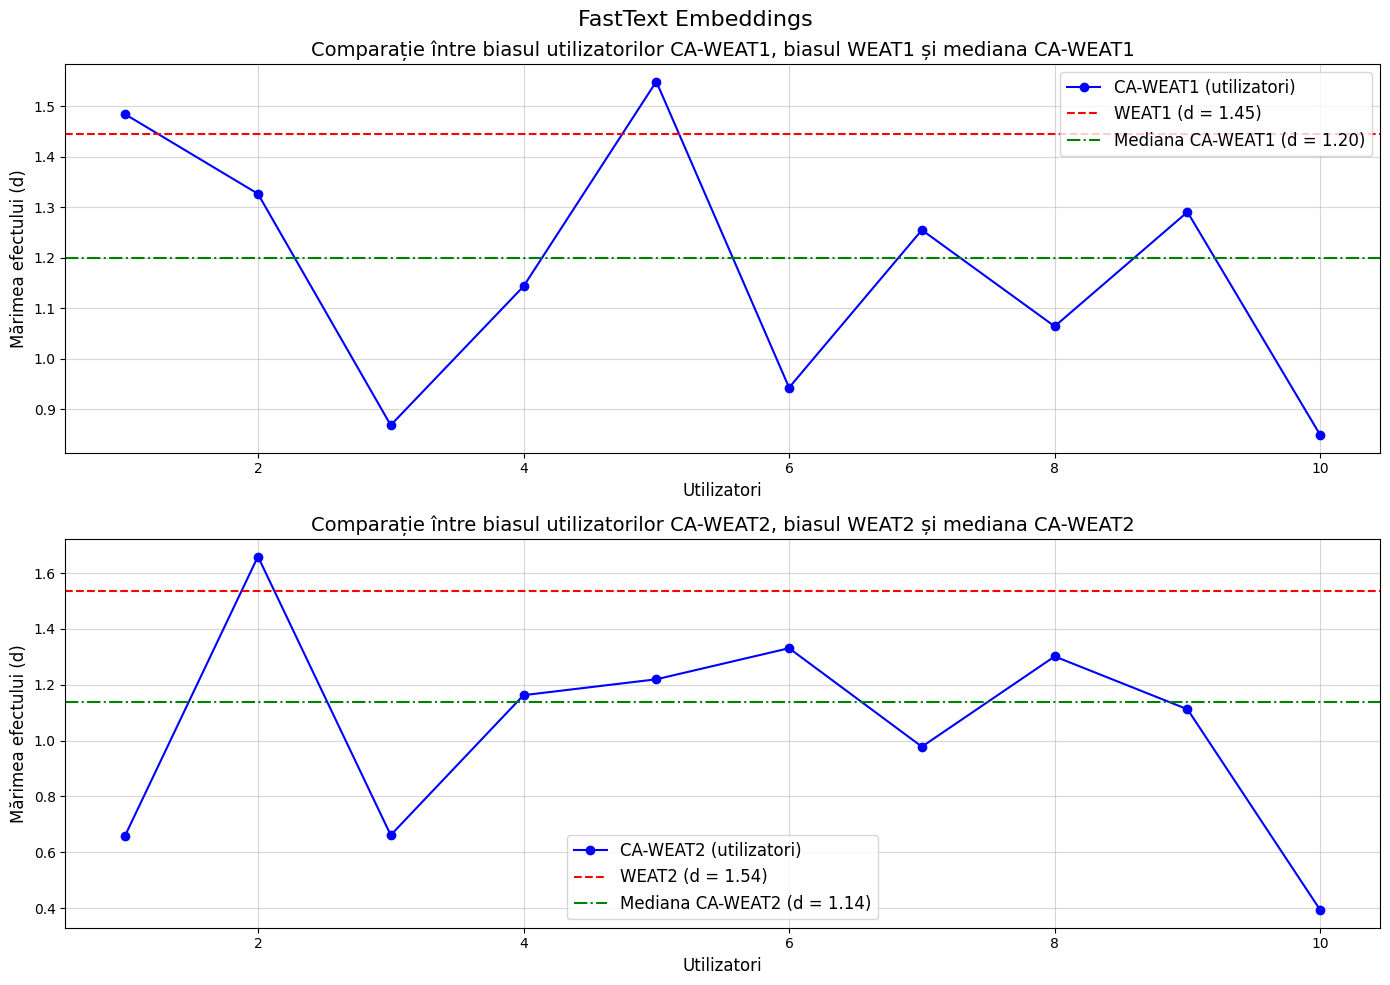

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Datele pentru graficele WEAT1 și WEAT2
# WEAT1
users_ca_weat1 = range(1, len(effect_sizes_ca_weat1_fasttext) + 1)
effect_sizes_ca_weat1 = effect_sizes_ca_weat1_fasttext  # Bias utilizatori pentru CA-WEAT1
weat1_effect_size = effect_size_weat1_fasttext  # Bias WEAT1
median_d_ca_weat1 = median_d_ca_weat1_fasttext  # Mediana pentru CA-WEAT1

# WEAT2
users_ca_weat2 = range(1, len(effect_sizes_ca_weat2_fasttext) + 1)
effect_sizes_ca_weat2 = effect_sizes_ca_weat2_fasttext  # Bias utilizatori pentru CA-WEAT2
weat2_effect_size = effect_size_weat2_fasttext  # Bias WEAT2
median_d_ca_weat2 = median_d_ca_weat2_fasttext  # Mediana pentru CA-WEAT2

# Crearea figurii cu 2 grafice
plt.figure(figsize=(14, 10))
# Titlu general
plt.suptitle("FastText Embeddings", fontsize=16)

# Subplot pentru WEAT1 și CA-WEAT1
plt.subplot(2, 1, 1)
plt.plot(users_ca_weat1, effect_sizes_ca_weat1, marker='o', label='CA-WEAT1 (utilizatori)', color='blue')
plt.axhline(y=weat1_effect_size, color='red', linestyle='--', label=f'WEAT1 (d = {weat1_effect_size:.2f})')
plt.axhline(y=median_d_ca_weat1, color='green', linestyle='-.', label=f'Mediana CA-WEAT1 (d = {median_d_ca_weat1:.2f})')
plt.title("Comparație între biasul utilizatorilor CA-WEAT1, biasul WEAT1 și mediana CA-WEAT1", fontsize=14)
plt.xlabel("Utilizatori", fontsize=12)
plt.ylabel("Mărimea efectului (d)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Subplot pentru WEAT2 și CA-WEAT2
plt.subplot(2, 1, 2)
plt.plot(users_ca_weat2, effect_sizes_ca_weat2, marker='o', label='CA-WEAT2 (utilizatori)', color='blue')
plt.axhline(y=weat2_effect_size, color='red', linestyle='--', label=f'WEAT2 (d = {weat2_effect_size:.2f})')
plt.axhline(y=median_d_ca_weat2, color='green', linestyle='-.', label=f'Mediana CA-WEAT2 (d = {median_d_ca_weat2:.2f})')
plt.title("Comparație între biasul utilizatorilor CA-WEAT2, biasul WEAT2 și mediana CA-WEAT2", fontsize=14)
plt.xlabel("Utilizatori", fontsize=12)
plt.ylabel("Mărimea efectului (d)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Afișarea graficelor
plt.tight_layout()
plt.show()


### WEAT1 pentru embedding-uri mBERT

In [41]:
# Datele pentru WEAT1 pentru mBERT
flowers_vectors_weat1_mbert = weat_embeddings_mbert["Flori"]
insects_vectors_weat1_mbert = weat_embeddings_mbert["Insecte"]
pleasant_vectors_weat1_mbert = weat_embeddings_mbert["Plăcut"]
unpleasant_vectors_weat1_mbert = weat_embeddings_mbert["Neplăcut"]

# Calculul diferențelor de asociere
delta_assoc_pleasant_weat1_mbert = [
    calculate_delta_assoc(vec, pleasant_vectors_weat1_mbert, unpleasant_vectors_weat1_mbert)
    for vec in flowers_vectors_weat1_mbert
]
delta_assoc_unpleasant_weat1_mbert = [
    calculate_delta_assoc(vec, pleasant_vectors_weat1_mbert, unpleasant_vectors_weat1_mbert)
    for vec in insects_vectors_weat1_mbert
]

# Calculul statisticii s
statistic_s_weat1_mbert = calculate_statistic_s(
    flowers_vectors_weat1_mbert, insects_vectors_weat1_mbert,
    pleasant_vectors_weat1_mbert, unpleasant_vectors_weat1_mbert
)

# Calculul mărimii efectului d
effect_size_weat1_mbert = calculate_effect_size(
    delta_assoc_pleasant_weat1_mbert, delta_assoc_unpleasant_weat1_mbert
)

# Bootstrap pentru intervale de încredere
ci_lower_s_weat1_mbert, ci_upper_s_weat1_mbert = bootstrap_confidence_interval(
    delta_assoc_pleasant_weat1_mbert + delta_assoc_unpleasant_weat1_mbert
)
ci_lower_d_weat1_mbert, ci_upper_d_weat1_mbert = bootstrap_confidence_interval(
    [effect_size_weat1_mbert]
)

print(f"Statistica s (WEAT1, mBERT): {statistic_s_weat1_mbert}")
print(f"Mărimea efectului d (WEAT1, mBERT): {effect_size_weat1_mbert}")
print(f"Intervale de încredere pentru d: [{ci_lower_d_weat1_mbert}, {ci_upper_d_weat1_mbert}]")


Statistica s (WEAT1, mBERT): 0.01436646655201912
Mărimea efectului d (WEAT1, mBERT): 0.7328047752380371
Intervale de încredere pentru d: [0.7328047752380371, 0.7328047752380371]


### CA-WEAT1 pentru embeddings mBERT

In [42]:
# Stocarea rezultatelor pentru utilizatori pentru CA-WEAT1 mBERT
statistics_s_ca_weat1_mbert = []
effect_sizes_ca_weat1_mbert = []

for user, data in ca_weat_embeddings_mbert.items():
    # Obține datele utilizatorului
    flowers_vectors_ca_weat1_mbert = data["flowers"]
    insects_vectors_ca_weat1_mbert = data["insects"]
    pleasant_vectors_ca_weat1_mbert = data["pleasant"]
    unpleasant_vectors_ca_weat1_mbert = data["unpleasant"]
    
    # Calcul statistică s
    statistic_s = calculate_statistic_s(
        flowers_vectors_ca_weat1_mbert, insects_vectors_ca_weat1_mbert,
        pleasant_vectors_ca_weat1_mbert, unpleasant_vectors_ca_weat1_mbert
    )
    
    # Calcul diferențe de asociere
    delta_assoc_pleasant = [
        calculate_delta_assoc(vec, pleasant_vectors_ca_weat1_mbert, unpleasant_vectors_ca_weat1_mbert)
        for vec in flowers_vectors_ca_weat1_mbert
    ]
    delta_assoc_unpleasant = [
        calculate_delta_assoc(vec, pleasant_vectors_ca_weat1_mbert, unpleasant_vectors_ca_weat1_mbert)
        for vec in insects_vectors_ca_weat1_mbert
    ]
    
    # Calcul mărime efect
    effect_size = calculate_effect_size(delta_assoc_pleasant, delta_assoc_unpleasant)
    
    # Salvează rezultatele
    statistics_s_ca_weat1_mbert.append(statistic_s)
    effect_sizes_ca_weat1_mbert.append(effect_size)

median_s_ca_weat1_mbert = np.median(statistics_s_ca_weat1_mbert)
median_d_ca_weat1_mbert = np.median(effect_sizes_ca_weat1_mbert)

# Conversie valori pentru afișare
statistics_s_ca_weat1_mbert = [float(val) for val in statistics_s_ca_weat1_mbert]
effect_sizes_ca_weat1_mbert = [float(val) for val in effect_sizes_ca_weat1_mbert]

# Afișare rezultate brute
print(f"Statisticile s pentru utilizatori (CA-WEAT1, mBERT): {statistics_s_ca_weat1_mbert}")
print(f"Mărimile efectului d pentru utilizatori (CA-WEAT1, mBERT): {effect_sizes_ca_weat1_mbert}")


Statisticile s pentru utilizatori (CA-WEAT1, mBERT): [0.0006561046466231346, 0.004163037985563278, 0.0018837451934814453, -0.0025514757726341486, 0.0026505962014198303, -0.0035731950774788857, -0.0048150839284062386, -0.0031542982906103134, 0.00921938382089138, 0.0014508608728647232]
Mărimile efectului d pentru utilizatori (CA-WEAT1, mBERT): [0.04952772706747055, 0.2515670359134674, 0.11614026874303818, -0.17287616431713104, 0.14875386655330658, -0.23968692123889923, -0.4012698531150818, -0.22061613202095032, 0.5273721218109131, 0.09334265440702438]


### WEAT2 pentru embeddings mBERT

In [43]:
# Datele pentru WEAT2 pentru mBERT
musical_instruments_vectors_weat2_mbert = weat_embeddings_mbert["Instrumente Muzicale"]
weapons_vectors_weat2_mbert = weat_embeddings_mbert["Arme"]
pleasant_vectors_weat2_mbert = weat_embeddings_mbert["Plăcut"]
unpleasant_vectors_weat2_mbert = weat_embeddings_mbert["Neplăcut"]

# Calculul diferențelor de asociere
delta_assoc_pleasant_weat2_mbert = [
    calculate_delta_assoc(vec, pleasant_vectors_weat2_mbert, unpleasant_vectors_weat2_mbert)
    for vec in musical_instruments_vectors_weat2_mbert
]
delta_assoc_unpleasant_weat2_mbert = [
    calculate_delta_assoc(vec, pleasant_vectors_weat2_mbert, unpleasant_vectors_weat2_mbert)
    for vec in weapons_vectors_weat2_mbert
]

# Calculul statisticii s
statistic_s_weat2_mbert = calculate_statistic_s(
    musical_instruments_vectors_weat2_mbert, weapons_vectors_weat2_mbert,
    pleasant_vectors_weat2_mbert, unpleasant_vectors_weat2_mbert
)

# Calculul mărimii efectului d
effect_size_weat2_mbert = calculate_effect_size(
    delta_assoc_pleasant_weat2_mbert, delta_assoc_unpleasant_weat2_mbert
)

# Bootstrap pentru intervale de încredere
ci_lower_s_weat2_mbert, ci_upper_s_weat2_mbert = bootstrap_confidence_interval(
    delta_assoc_pleasant_weat2_mbert + delta_assoc_unpleasant_weat2_mbert
)
ci_lower_d_weat2_mbert, ci_upper_d_weat2_mbert = bootstrap_confidence_interval(
    [effect_size_weat2_mbert]
)

print(f"Statistica s (WEAT2, mBERT): {statistic_s_weat2_mbert}")
print(f"Mărimea efectului d (WEAT2, mBERT): {effect_size_weat2_mbert}")
print(f"Intervale de încredere pentru d: [{ci_lower_d_weat2_mbert}, {ci_upper_d_weat2_mbert}]")


Statistica s (WEAT2, mBERT): 0.014944817870855331
Mărimea efectului d (WEAT2, mBERT): 0.68983393907547
Intervale de încredere pentru d: [0.68983393907547, 0.68983393907547]


### CA-WEAT2 pentru embeddings mBERT

In [44]:
# Stocarea rezultatelor pentru utilizatori pentru CA-WEAT2 mBERT
statistics_s_ca_weat2_mbert = []
effect_sizes_ca_weat2_mbert = []

for user, data in ca_weat_embeddings_mbert.items():
    # Obține datele utilizatorului
    musical_instruments_vectors_ca_weat2_mbert = data["instruments"]
    weapons_vectors_ca_weat2_mbert = data["weapons"]
    pleasant_vectors_ca_weat2_mbert = data["pleasant"]
    unpleasant_vectors_ca_weat2_mbert = data["unpleasant"]
    
    # Calcul statistică s
    statistic_s = calculate_statistic_s(
        musical_instruments_vectors_ca_weat2_mbert, weapons_vectors_ca_weat2_mbert,
        pleasant_vectors_ca_weat2_mbert, unpleasant_vectors_ca_weat2_mbert
    )
    
    # Calcul diferențe de asociere
    delta_assoc_pleasant = [
        calculate_delta_assoc(vec, pleasant_vectors_ca_weat2_mbert, unpleasant_vectors_ca_weat2_mbert)
        for vec in musical_instruments_vectors_ca_weat2_mbert
    ]
    delta_assoc_unpleasant = [
        calculate_delta_assoc(vec, pleasant_vectors_ca_weat2_mbert, unpleasant_vectors_ca_weat2_mbert)
        for vec in weapons_vectors_ca_weat2_mbert
    ]
    
    # Calcul mărime efect
    effect_size = calculate_effect_size(delta_assoc_pleasant, delta_assoc_unpleasant)
    
    # Salvează rezultatele
    statistics_s_ca_weat2_mbert.append(statistic_s)
    effect_sizes_ca_weat2_mbert.append(effect_size)

median_d_ca_weat2_mbert = np.median(effect_sizes_ca_weat2_mbert)
median_s_ca_weat2_mbert = np.median(statistics_s_ca_weat2_mbert)

# Conversie valori pentru afișare
statistics_s_ca_weat2_mbert = [float(val) for val in statistics_s_ca_weat2_mbert]
effect_sizes_ca_weat2_mbert = [float(val) for val in effect_sizes_ca_weat2_mbert]

# Afișare rezultate brute
print(f"Statisticile s pentru utilizatori (CA-WEAT2, mBERT): {statistics_s_ca_weat2_mbert}")
print(f"Mărimile efectului d pentru utilizatori (CA-WEAT2, mBERT): {effect_sizes_ca_weat2_mbert}")


Statisticile s pentru utilizatori (CA-WEAT2, mBERT): [-0.006455418653786182, 0.016393203288316727, 0.024081921204924583, 0.012070555239915848, 0.007831518538296223, 0.00793716311454773, -0.0032618511468172073, -0.00693479273468256, 0.005022099241614342, -0.007883882150053978]
Mărimile efectului d pentru utilizatori (CA-WEAT2, mBERT): [-0.5217849016189575, 0.8454065322875977, 0.9641463756561279, 0.6741718053817749, 0.37070903182029724, 0.5290107131004333, -0.2747868001461029, -0.39506208896636963, 0.3468482196331024, -0.5230146646499634]


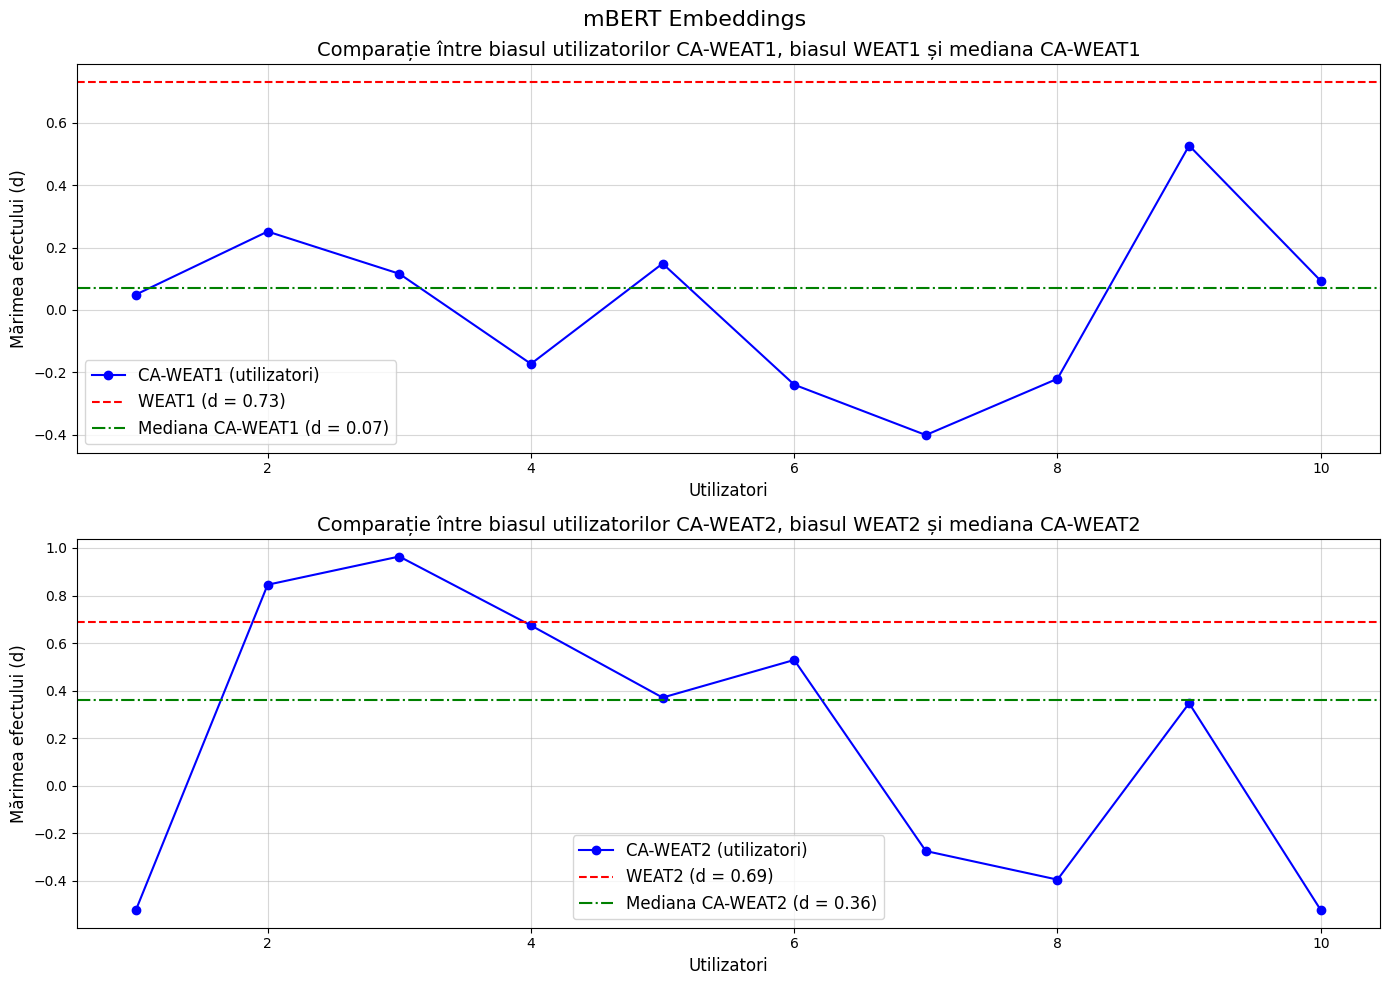

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Datele pentru graficele WEAT1 și WEAT2 pentru mBERT
# WEAT1
users_ca_weat1 = range(1, len(effect_sizes_ca_weat1_mbert) + 1)
effect_sizes_ca_weat1 = effect_sizes_ca_weat1_mbert  # Bias utilizatori pentru CA-WEAT1
weat1_effect_size = effect_size_weat1_mbert  # Bias WEAT1
median_d_ca_weat1 = median_d_ca_weat1_mbert  # Mediana pentru CA-WEAT1

# WEAT2
users_ca_weat2 = range(1, len(effect_sizes_ca_weat2_mbert) + 1)
effect_sizes_ca_weat2 = effect_sizes_ca_weat2_mbert  # Bias utilizatori pentru CA-WEAT2
weat2_effect_size = effect_size_weat2_mbert  # Bias WEAT2
median_d_ca_weat2 = median_d_ca_weat2_mbert  # Mediana pentru CA-WEAT2

# Crearea figurii cu 2 grafice
plt.figure(figsize=(14, 10))
# Titlu general
plt.suptitle("mBERT Embeddings", fontsize=16)

# Subplot pentru WEAT1 și CA-WEAT1
plt.subplot(2, 1, 1)
plt.plot(users_ca_weat1, effect_sizes_ca_weat1, marker='o', label='CA-WEAT1 (utilizatori)', color='blue')
plt.axhline(y=weat1_effect_size, color='red', linestyle='--', label=f'WEAT1 (d = {weat1_effect_size:.2f})')
plt.axhline(y=median_d_ca_weat1, color='green', linestyle='-.', label=f'Mediana CA-WEAT1 (d = {median_d_ca_weat1:.2f})')
plt.title("Comparație între biasul utilizatorilor CA-WEAT1, biasul WEAT1 și mediana CA-WEAT1", fontsize=14)
plt.xlabel("Utilizatori", fontsize=12)
plt.ylabel("Mărimea efectului (d)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Subplot pentru WEAT2 și CA-WEAT2
plt.subplot(2, 1, 2)
plt.plot(users_ca_weat2, effect_sizes_ca_weat2, marker='o', label='CA-WEAT2 (utilizatori)', color='blue')
plt.axhline(y=weat2_effect_size, color='red', linestyle='--', label=f'WEAT2 (d = {weat2_effect_size:.2f})')
plt.axhline(y=median_d_ca_weat2, color='green', linestyle='-.', label=f'Mediana CA-WEAT2 (d = {median_d_ca_weat2:.2f})')
plt.title("Comparație între biasul utilizatorilor CA-WEAT2, biasul WEAT2 și mediana CA-WEAT2", fontsize=14)
plt.xlabel("Utilizatori", fontsize=12)
plt.ylabel("Mărimea efectului (d)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Afișarea graficelor
plt.tight_layout()
plt.show()


### WEAT1 pentru embeddings XLM-R

In [46]:
# Datele pentru WEAT1 pentru XLM-R
flowers_vectors_weat1_xlmr = weat_embeddings_xlmr["Flori"]
insects_vectors_weat1_xlmr = weat_embeddings_xlmr["Insecte"]
pleasant_vectors_weat1_xlmr = weat_embeddings_xlmr["Plăcut"]
unpleasant_vectors_weat1_xlmr = weat_embeddings_xlmr["Neplăcut"]

# Calculul diferențelor de asociere
delta_assoc_pleasant_weat1_xlmr = [
    calculate_delta_assoc(vec, pleasant_vectors_weat1_xlmr, unpleasant_vectors_weat1_xlmr)
    for vec in flowers_vectors_weat1_xlmr
]
delta_assoc_unpleasant_weat1_xlmr = [
    calculate_delta_assoc(vec, pleasant_vectors_weat1_xlmr, unpleasant_vectors_weat1_xlmr)
    for vec in insects_vectors_weat1_xlmr
]

# Calculul statisticii s
statistic_s_weat1_xlmr = calculate_statistic_s(
    flowers_vectors_weat1_xlmr, insects_vectors_weat1_xlmr,
    pleasant_vectors_weat1_xlmr, unpleasant_vectors_weat1_xlmr
)

# Calculul mărimii efectului d
effect_size_weat1_xlmr = calculate_effect_size(
    delta_assoc_pleasant_weat1_xlmr, delta_assoc_unpleasant_weat1_xlmr
)

# Bootstrap pentru intervale de încredere
ci_lower_s_weat1_xlmr, ci_upper_s_weat1_xlmr = bootstrap_confidence_interval(
    delta_assoc_pleasant_weat1_xlmr + delta_assoc_unpleasant_weat1_xlmr
)
ci_lower_d_weat1_xlmr, ci_upper_d_weat1_xlmr = bootstrap_confidence_interval(
    [effect_size_weat1_xlmr]
)

print(f"Statistica s (WEAT1, XLM-R): {statistic_s_weat1_xlmr}")
print(f"Mărimea efectului d (WEAT1, XLM-R): {effect_size_weat1_xlmr}")
print(f"Intervale de încredere pentru d: [{ci_lower_d_weat1_xlmr}, {ci_upper_d_weat1_xlmr}]")


Statistica s (WEAT1, XLM-R): 0.00046719302190467715
Mărimea efectului d (WEAT1, XLM-R): 0.45120057463645935
Intervale de încredere pentru d: [0.45120057463645935, 0.45120057463645935]


### CA-WEAT1 pentru embeddings XLM-R

In [47]:
# Stocarea rezultatelor pentru utilizatori pentru CA-WEAT1 XLM-R
statistics_s_ca_weat1_xlmr = []
effect_sizes_ca_weat1_xlmr = []

for user, data in ca_weat_embeddings_xlmr.items():
    # Obține datele utilizatorului
    flowers_vectors_ca_weat1_xlmr = data["flowers"]
    insects_vectors_ca_weat1_xlmr = data["insects"]
    pleasant_vectors_ca_weat1_xlmr = data["pleasant"]
    unpleasant_vectors_ca_weat1_xlmr = data["unpleasant"]
    
    # Calcul statistică s
    statistic_s = calculate_statistic_s(
        flowers_vectors_ca_weat1_xlmr, insects_vectors_ca_weat1_xlmr,
        pleasant_vectors_ca_weat1_xlmr, unpleasant_vectors_ca_weat1_xlmr
    )
    
    # Calcul diferențe de asociere
    delta_assoc_pleasant = [
        calculate_delta_assoc(vec, pleasant_vectors_ca_weat1_xlmr, unpleasant_vectors_ca_weat1_xlmr)
        for vec in flowers_vectors_ca_weat1_xlmr
    ]
    delta_assoc_unpleasant = [
        calculate_delta_assoc(vec, pleasant_vectors_ca_weat1_xlmr, unpleasant_vectors_ca_weat1_xlmr)
        for vec in insects_vectors_ca_weat1_xlmr
    ]
    
    # Calcul mărime efect
    effect_size = calculate_effect_size(delta_assoc_pleasant, delta_assoc_unpleasant)
    
    # Salvează rezultatele
    statistics_s_ca_weat1_xlmr.append(statistic_s)
    effect_sizes_ca_weat1_xlmr.append(effect_size)
    
median_d_ca_weat1_xlmr = np.median(effect_sizes_ca_weat1_xlmr)
median_s_ca_weat1_xlmr = np.median(statistics_s_ca_weat1_xlmr)

# Conversie valori pentru afișare
statistics_s_ca_weat1_xlmr = [float(val) for val in statistics_s_ca_weat1_xlmr]
effect_sizes_ca_weat1_xlmr = [float(val) for val in effect_sizes_ca_weat1_xlmr]

# Afișare rezultate brute
print(f"Statisticile s pentru utilizatori (CA-WEAT1, XLM-R): {statistics_s_ca_weat1_xlmr}")
print(f"Mărimile efectului d pentru utilizatori (CA-WEAT1, XLM-R): {effect_sizes_ca_weat1_xlmr}")


Statisticile s pentru utilizatori (CA-WEAT1, XLM-R): [0.0006724023260176182, 0.0001979803928406909, 0.00035784952342510223, 0.0006205302197486162, -0.00014291994739323854, 0.00029772272682748735, 0.00035419236519373953, 0.0002247572410851717, 0.00025936594465747476, 0.0003389464982319623]
Mărimile efectului d pentru utilizatori (CA-WEAT1, XLM-R): [0.5105028748512268, 0.1038726419210434, 0.2317688763141632, 0.3488885164260864, -0.15523605048656464, 0.42038285732269287, 0.2183564007282257, 0.09929059445858002, 0.2272142916917801, 0.2672518789768219]


### WEAT2 pentru embeddings XLM-R

In [48]:
# Datele pentru WEAT2 pentru XLM-R
musical_instruments_vectors_weat2_xlmr = weat_embeddings_xlmr["Instrumente Muzicale"]
weapons_vectors_weat2_xlmr = weat_embeddings_xlmr["Arme"]
pleasant_vectors_weat2_xlmr = weat_embeddings_xlmr["Plăcut"]
unpleasant_vectors_weat2_xlmr = weat_embeddings_xlmr["Neplăcut"]

# Calculul diferențelor de asociere
delta_assoc_pleasant_weat2_xlmr = [
    calculate_delta_assoc(vec, pleasant_vectors_weat2_xlmr, unpleasant_vectors_weat2_xlmr)
    for vec in musical_instruments_vectors_weat2_xlmr
]
delta_assoc_unpleasant_weat2_xlmr = [
    calculate_delta_assoc(vec, pleasant_vectors_weat2_xlmr, unpleasant_vectors_weat2_xlmr)
    for vec in weapons_vectors_weat2_xlmr
]

# Calculul statisticii s
statistic_s_weat2_xlmr = calculate_statistic_s(
    musical_instruments_vectors_weat2_xlmr, weapons_vectors_weat2_xlmr,
    pleasant_vectors_weat2_xlmr, unpleasant_vectors_weat2_xlmr
)

# Calculul mărimii efectului d
effect_size_weat2_xlmr = calculate_effect_size(
    delta_assoc_pleasant_weat2_xlmr, delta_assoc_unpleasant_weat2_xlmr
)

# Bootstrap pentru intervale de încredere
ci_lower_s_weat2_xlmr, ci_upper_s_weat2_xlmr = bootstrap_confidence_interval(
    delta_assoc_pleasant_weat2_xlmr + delta_assoc_unpleasant_weat2_xlmr
)
ci_lower_d_weat2_xlmr, ci_upper_d_weat2_xlmr = bootstrap_confidence_interval(
    [effect_size_weat2_xlmr]
)

print(f"Statistica s (WEAT2, XLM-R): {statistic_s_weat2_xlmr}")
print(f"Mărimea efectului d (WEAT2, XLM-R): {effect_size_weat2_xlmr}")
print(f"Intervale de încredere pentru d: [{ci_lower_d_weat2_xlmr}, {ci_upper_d_weat2_xlmr}]")


Statistica s (WEAT2, XLM-R): 0.00011103597353212535
Mărimea efectului d (WEAT2, XLM-R): 0.10960429161787033
Intervale de încredere pentru d: [0.10960429161787033, 0.10960429161787033]


### CA-WEAT2 pentru embeddings XLM-R

In [50]:
# Stocarea rezultatelor pentru utilizatori pentru CA-WEAT2 XLM-R
statistics_s_ca_weat2_xlmr = []
effect_sizes_ca_weat2_xlmr = []

for user, data in ca_weat_embeddings_xlmr.items():
    # Obține datele utilizatorului
    musical_instruments_vectors_ca_weat2_xlmr = data["instruments"]
    weapons_vectors_ca_weat2_xlmr = data["weapons"]
    pleasant_vectors_ca_weat2_xlmr = data["pleasant"]
    unpleasant_vectors_ca_weat2_xlmr = data["unpleasant"]
    
    # Calcul statistică s
    statistic_s = calculate_statistic_s(
        musical_instruments_vectors_ca_weat2_xlmr, weapons_vectors_ca_weat2_xlmr,
        pleasant_vectors_ca_weat2_xlmr, unpleasant_vectors_ca_weat2_xlmr
    )
    
    # Calcul diferențe de asociere
    delta_assoc_pleasant = [
        calculate_delta_assoc(vec, pleasant_vectors_ca_weat2_xlmr, unpleasant_vectors_ca_weat2_xlmr)
        for vec in musical_instruments_vectors_ca_weat2_xlmr
    ]
    delta_assoc_unpleasant = [
        calculate_delta_assoc(vec, pleasant_vectors_ca_weat2_xlmr, unpleasant_vectors_ca_weat2_xlmr)
        for vec in weapons_vectors_ca_weat2_xlmr
    ]
    
    # Calcul mărime efect
    effect_size = calculate_effect_size(delta_assoc_pleasant, delta_assoc_unpleasant)
    
    # Salvează rezultatele
    statistics_s_ca_weat2_xlmr.append(statistic_s)
    effect_sizes_ca_weat2_xlmr.append(effect_size)

# Conversie valori pentru afișare
statistics_s_ca_weat2_xlmr = [float(val) for val in statistics_s_ca_weat2_xlmr]
effect_sizes_ca_weat2_xlmr = [float(val) for val in effect_sizes_ca_weat2_xlmr]

# Afișare rezultate brute
print(f"Statisticile s pentru utilizatori (CA-WEAT2, XLM-R): {statistics_s_ca_weat2_xlmr}")
print(f"Mărimile efectului d pentru utilizatori (CA-WEAT2, XLM-R): {effect_sizes_ca_weat2_xlmr}")

# Calcul mediana pentru s și d
median_s_ca_weat2_xlmr = np.median(statistics_s_ca_weat2_xlmr)
median_d_ca_weat2_xlmr = np.median(effect_sizes_ca_weat2_xlmr)

# Bootstrap pentru intervale de încredere
ci_lower_s_ca_weat2_xlmr, ci_upper_s_ca_weat2_xlmr = bootstrap_confidence_interval(
    statistics_s_ca_weat2_xlmr
)
ci_lower_d_ca_weat2_xlmr, ci_upper_d_ca_weat2_xlmr = bootstrap_confidence_interval(
    effect_sizes_ca_weat2_xlmr
)

print(f"Mediana statisticii s (CA-WEAT2, XLM-R): {median_s_ca_weat2_xlmr}, Interval: [{ci_lower_s_ca_weat2_xlmr}, {ci_upper_s_ca_weat2_xlmr}]")
print(f"Mediana mărimii efectului d (CA-WEAT2, XLM-R): {median_d_ca_weat2_xlmr}, Interval: [{ci_lower_d_ca_weat2_xlmr}, {ci_upper_d_ca_weat2_xlmr}]")


Statisticile s pentru utilizatori (CA-WEAT2, XLM-R): [6.440095603466034e-07, -0.00027152159600518644, -0.00011978810653090477, 0.00016623502597212791, -0.0005688356468454003, 0.0003258919750805944, 0.00024196307640522718, 6.82012178003788e-05, 0.00020691630197688937, -0.0001886177051346749]
Mărimile efectului d pentru utilizatori (CA-WEAT2, XLM-R): [0.0007841769838705659, -0.15294018387794495, -0.0865929052233696, 0.0914245992898941, -0.3467669188976288, 0.4093762934207916, 0.14659398794174194, 0.03839162737131119, 0.22369495034217834, -0.1450253576040268]
Mediana statisticii s (CA-WEAT2, XLM-R): 3.44226136803627e-05, Interval: [-0.0001883834367617964, 0.00013916644988057667]
Mediana mărimii efectului d (CA-WEAT2, XLM-R): 0.019587902177590877, Interval: [-0.10315074485173681, 0.14502985008904937]


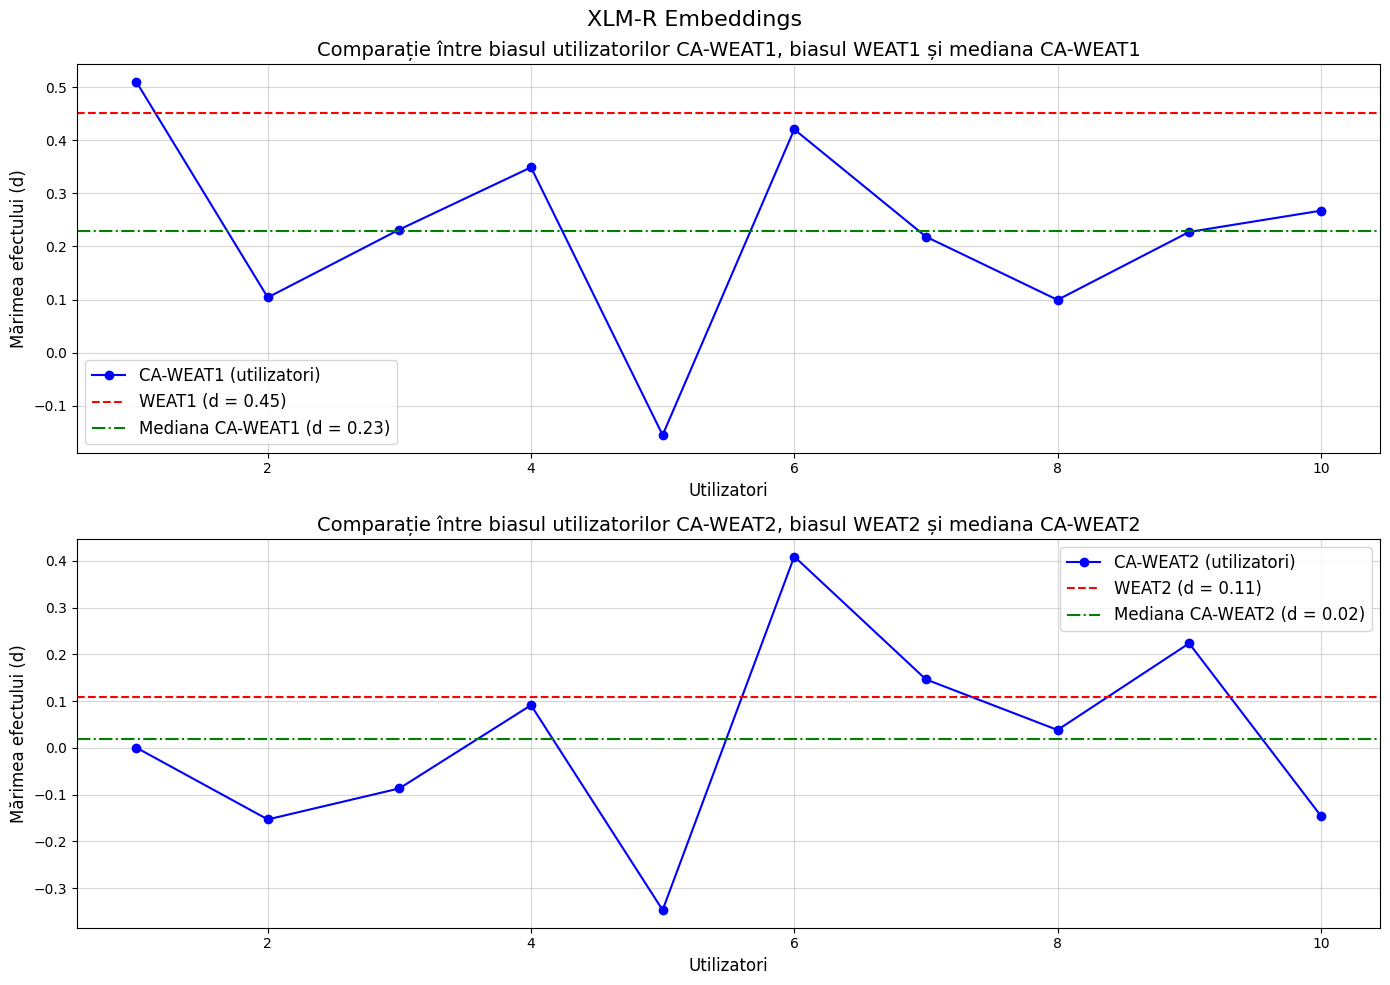

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Datele pentru graficele WEAT1 și WEAT2 pentru XLM-R
# WEAT1
users_ca_weat1 = range(1, len(effect_sizes_ca_weat1_xlmr) + 1)
effect_sizes_ca_weat1 = effect_sizes_ca_weat1_xlmr  # Bias utilizatori pentru CA-WEAT1
weat1_effect_size = effect_size_weat1_xlmr  # Bias WEAT1
median_d_ca_weat1 = median_d_ca_weat1_xlmr  # Mediana pentru CA-WEAT1

# WEAT2
users_ca_weat2 = range(1, len(effect_sizes_ca_weat2_xlmr) + 1)
effect_sizes_ca_weat2 = effect_sizes_ca_weat2_xlmr  # Bias utilizatori pentru CA-WEAT2
weat2_effect_size = effect_size_weat2_xlmr  # Bias WEAT2
median_d_ca_weat2 = median_d_ca_weat2_xlmr  # Mediana pentru CA-WEAT2

# Crearea figurii cu 2 grafice
plt.figure(figsize=(14, 10))
# Titlu general
plt.suptitle("XLM-R Embeddings", fontsize=16)

# Subplot pentru WEAT1 și CA-WEAT1
plt.subplot(2, 1, 1)
plt.plot(users_ca_weat1, effect_sizes_ca_weat1, marker='o', label='CA-WEAT1 (utilizatori)', color='blue')
plt.axhline(y=weat1_effect_size, color='red', linestyle='--', label=f'WEAT1 (d = {weat1_effect_size:.2f})')
plt.axhline(y=median_d_ca_weat1, color='green', linestyle='-.', label=f'Mediana CA-WEAT1 (d = {median_d_ca_weat1:.2f})')
plt.title("Comparație între biasul utilizatorilor CA-WEAT1, biasul WEAT1 și mediana CA-WEAT1", fontsize=14)
plt.xlabel("Utilizatori", fontsize=12)
plt.ylabel("Mărimea efectului (d)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Subplot pentru WEAT2 și CA-WEAT2
plt.subplot(2, 1, 2)
plt.plot(users_ca_weat2, effect_sizes_ca_weat2, marker='o', label='CA-WEAT2 (utilizatori)', color='blue')
plt.axhline(y=weat2_effect_size, color='red', linestyle='--', label=f'WEAT2 (d = {weat2_effect_size:.2f})')
plt.axhline(y=median_d_ca_weat2, color='green', linestyle='-.', label=f'Mediana CA-WEAT2 (d = {median_d_ca_weat2:.2f})')
plt.title("Comparație între biasul utilizatorilor CA-WEAT2, biasul WEAT2 și mediana CA-WEAT2", fontsize=14)
plt.xlabel("Utilizatori", fontsize=12)
plt.ylabel("Mărimea efectului (d)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Afișarea graficelor
plt.tight_layout()
plt.show()


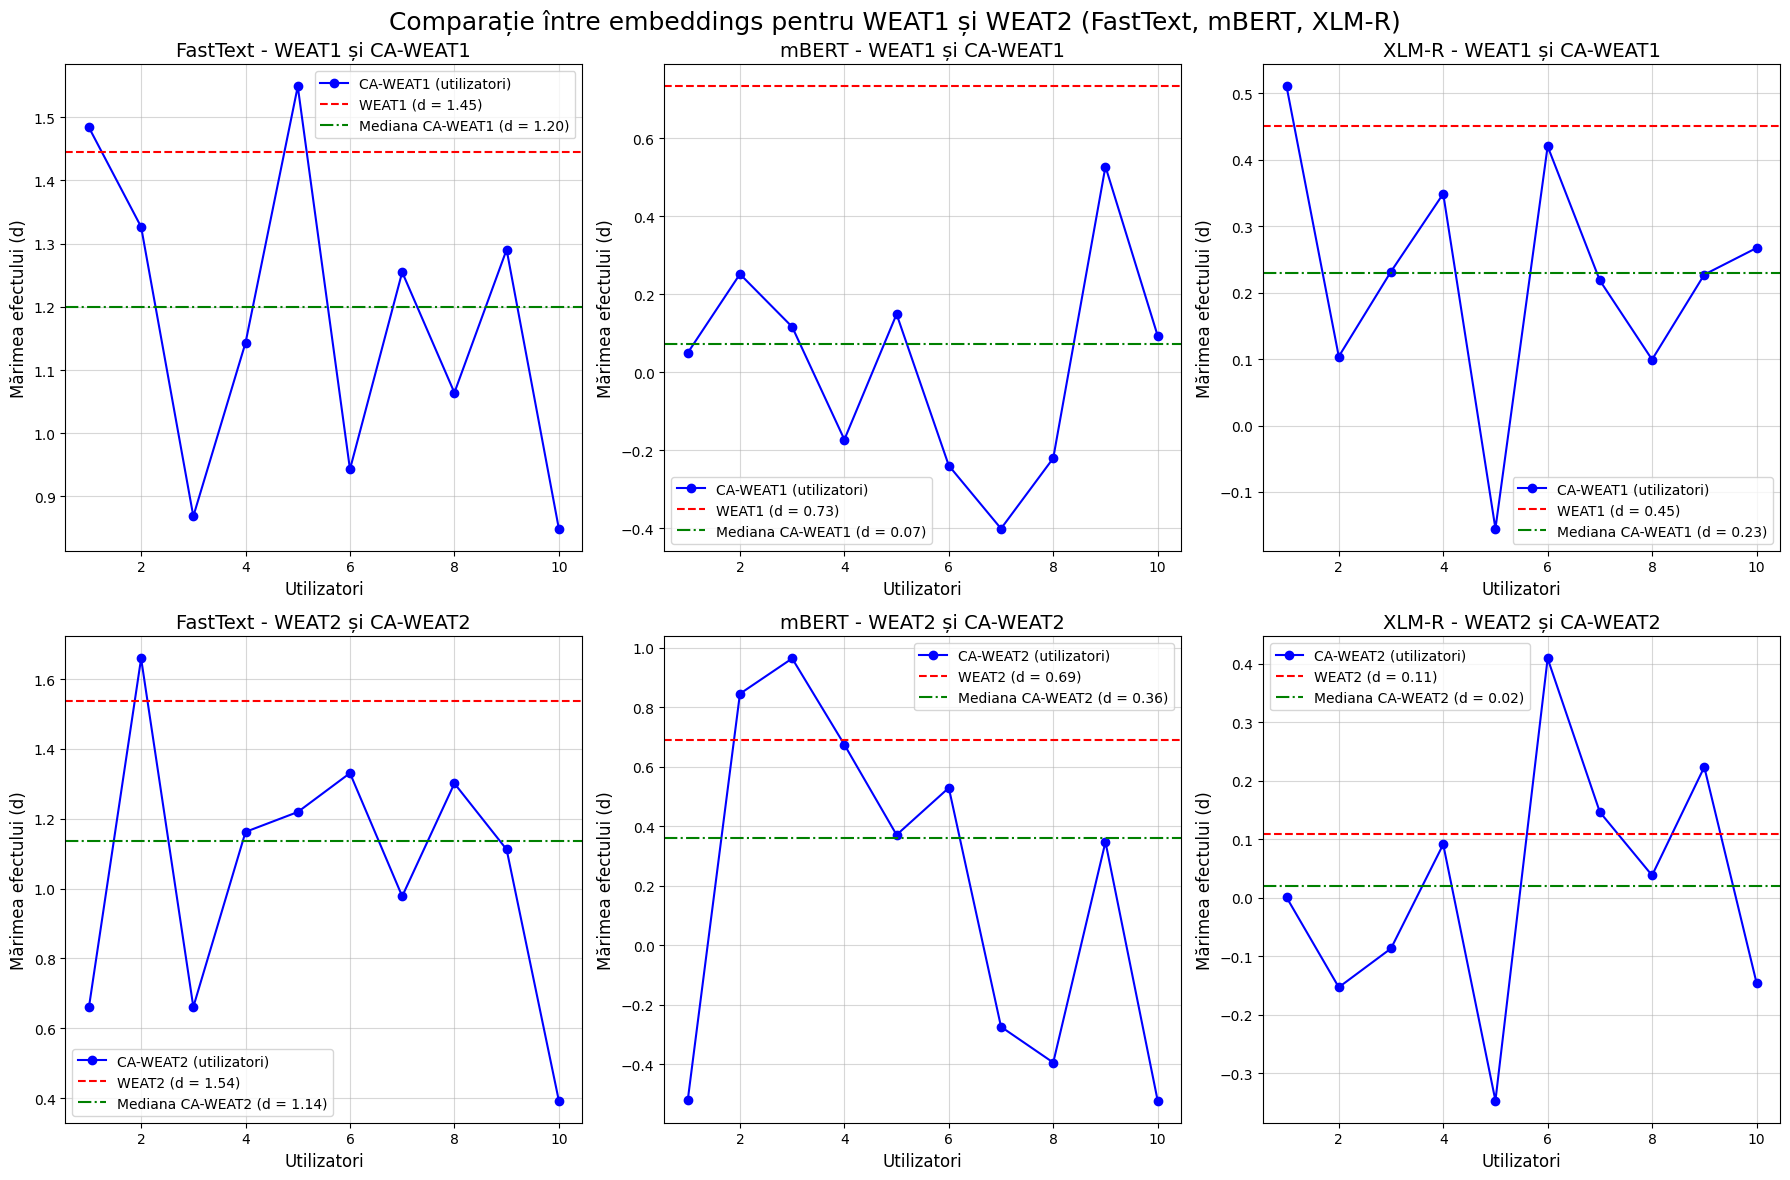

In [52]:
# Crearea figurii cu 2 rânduri și 3 coloane pentru toate modelele
plt.figure(figsize=(18, 12))
# Titlu general
plt.suptitle("Comparație între embeddings pentru WEAT1 și WEAT2 (FastText, mBERT, XLM-R)", fontsize=18)

# --- FastText ---
# WEAT1 și CA-WEAT1 pentru FastText
plt.subplot(2, 3, 1)
plt.plot(users_ca_weat1, effect_sizes_ca_weat1_fasttext, marker='o', label='CA-WEAT1 (utilizatori)', color='blue')
plt.axhline(y=effect_size_weat1_fasttext, color='red', linestyle='--', label=f'WEAT1 (d = {effect_size_weat1_fasttext:.2f})')
plt.axhline(y=median_d_ca_weat1_fasttext, color='green', linestyle='-.', label=f'Mediana CA-WEAT1 (d = {median_d_ca_weat1_fasttext:.2f})')
plt.title("FastText - WEAT1 și CA-WEAT1", fontsize=14)
plt.xlabel("Utilizatori", fontsize=12)
plt.ylabel("Mărimea efectului (d)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)

# WEAT2 și CA-WEAT2 pentru FastText
plt.subplot(2, 3, 4)
plt.plot(users_ca_weat2, effect_sizes_ca_weat2_fasttext, marker='o', label='CA-WEAT2 (utilizatori)', color='blue')
plt.axhline(y=effect_size_weat2_fasttext, color='red', linestyle='--', label=f'WEAT2 (d = {effect_size_weat2_fasttext:.2f})')
plt.axhline(y=median_d_ca_weat2_fasttext, color='green', linestyle='-.', label=f'Mediana CA-WEAT2 (d = {median_d_ca_weat2_fasttext:.2f})')
plt.title("FastText - WEAT2 și CA-WEAT2", fontsize=14)
plt.xlabel("Utilizatori", fontsize=12)
plt.ylabel("Mărimea efectului (d)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)

# --- mBERT ---
# WEAT1 și CA-WEAT1 pentru mBERT
plt.subplot(2, 3, 2)
plt.plot(users_ca_weat1, effect_sizes_ca_weat1_mbert, marker='o', label='CA-WEAT1 (utilizatori)', color='blue')
plt.axhline(y=effect_size_weat1_mbert, color='red', linestyle='--', label=f'WEAT1 (d = {effect_size_weat1_mbert:.2f})')
plt.axhline(y=median_d_ca_weat1_mbert, color='green', linestyle='-.', label=f'Mediana CA-WEAT1 (d = {median_d_ca_weat1_mbert:.2f})')
plt.title("mBERT - WEAT1 și CA-WEAT1", fontsize=14)
plt.xlabel("Utilizatori", fontsize=12)
plt.ylabel("Mărimea efectului (d)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)

# WEAT2 și CA-WEAT2 pentru mBERT
plt.subplot(2, 3, 5)
plt.plot(users_ca_weat2, effect_sizes_ca_weat2_mbert, marker='o', label='CA-WEAT2 (utilizatori)', color='blue')
plt.axhline(y=effect_size_weat2_mbert, color='red', linestyle='--', label=f'WEAT2 (d = {effect_size_weat2_mbert:.2f})')
plt.axhline(y=median_d_ca_weat2_mbert, color='green', linestyle='-.', label=f'Mediana CA-WEAT2 (d = {median_d_ca_weat2_mbert:.2f})')
plt.title("mBERT - WEAT2 și CA-WEAT2", fontsize=14)
plt.xlabel("Utilizatori", fontsize=12)
plt.ylabel("Mărimea efectului (d)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)

# --- XLM-R ---
# WEAT1 și CA-WEAT1 pentru XLM-R
plt.subplot(2, 3, 3)
plt.plot(users_ca_weat1, effect_sizes_ca_weat1_xlmr, marker='o', label='CA-WEAT1 (utilizatori)', color='blue')
plt.axhline(y=effect_size_weat1_xlmr, color='red', linestyle='--', label=f'WEAT1 (d = {effect_size_weat1_xlmr:.2f})')
plt.axhline(y=median_d_ca_weat1_xlmr, color='green', linestyle='-.', label=f'Mediana CA-WEAT1 (d = {median_d_ca_weat1_xlmr:.2f})')
plt.title("XLM-R - WEAT1 și CA-WEAT1", fontsize=14)
plt.xlabel("Utilizatori", fontsize=12)
plt.ylabel("Mărimea efectului (d)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)

# WEAT2 și CA-WEAT2 pentru XLM-R
plt.subplot(2, 3, 6)
plt.plot(users_ca_weat2, effect_sizes_ca_weat2_xlmr, marker='o', label='CA-WEAT2 (utilizatori)', color='blue')
plt.axhline(y=effect_size_weat2_xlmr, color='red', linestyle='--', label=f'WEAT2 (d = {effect_size_weat2_xlmr:.2f})')
plt.axhline(y=median_d_ca_weat2_xlmr, color='green', linestyle='-.', label=f'Mediana CA-WEAT2 (d = {median_d_ca_weat2_xlmr:.2f})')
plt.title("XLM-R - WEAT2 și CA-WEAT2", fontsize=14)
plt.xlabel("Utilizatori", fontsize=12)
plt.ylabel("Mărimea efectului (d)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)

# Afișarea graficelor
plt.tight_layout()
plt.show()


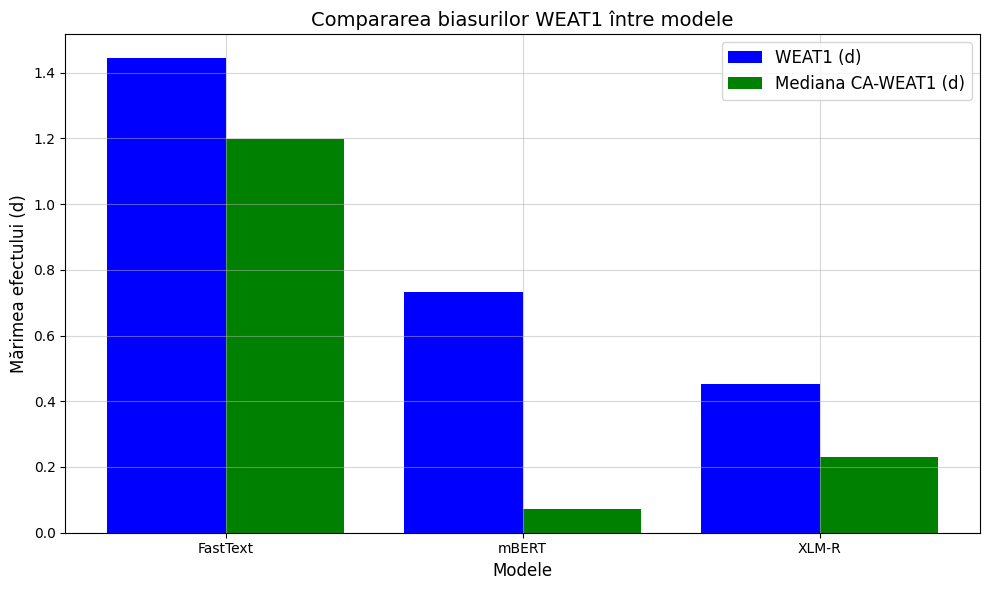

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Datele pentru WEAT1
models = ["FastText", "mBERT", "XLM-R"]
effect_sizes_weat1 = [
    effect_size_weat1_fasttext,
    effect_size_weat1_mbert,
    effect_size_weat1_xlmr
]
medians_ca_weat1 = [
    median_d_ca_weat1_fasttext,
    median_d_ca_weat1_mbert,
    median_d_ca_weat1_xlmr
]

# Crearea figurii
plt.figure(figsize=(10, 6))

# Bar chart pentru biasurile WEAT1
x = np.arange(len(models))  # Index pentru fiecare model
width = 0.4  # Lățimea barelor

# Plot pentru biasurile WEAT1
plt.bar(x - width/2, effect_sizes_weat1, width, label='WEAT1 (d)', color='blue')
# Plot pentru medianele CA-WEAT1
plt.bar(x + width/2, medians_ca_weat1, width, label='Mediana CA-WEAT1 (d)', color='green')

# Configurare axă și etichete
plt.xlabel("Modele", fontsize=12)
plt.ylabel("Mărimea efectului (d)", fontsize=12)
plt.title("Compararea biasurilor WEAT1 între modele", fontsize=14)
plt.xticks(x, models, fontsize=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Afișarea graficului
plt.tight_layout()
plt.show()


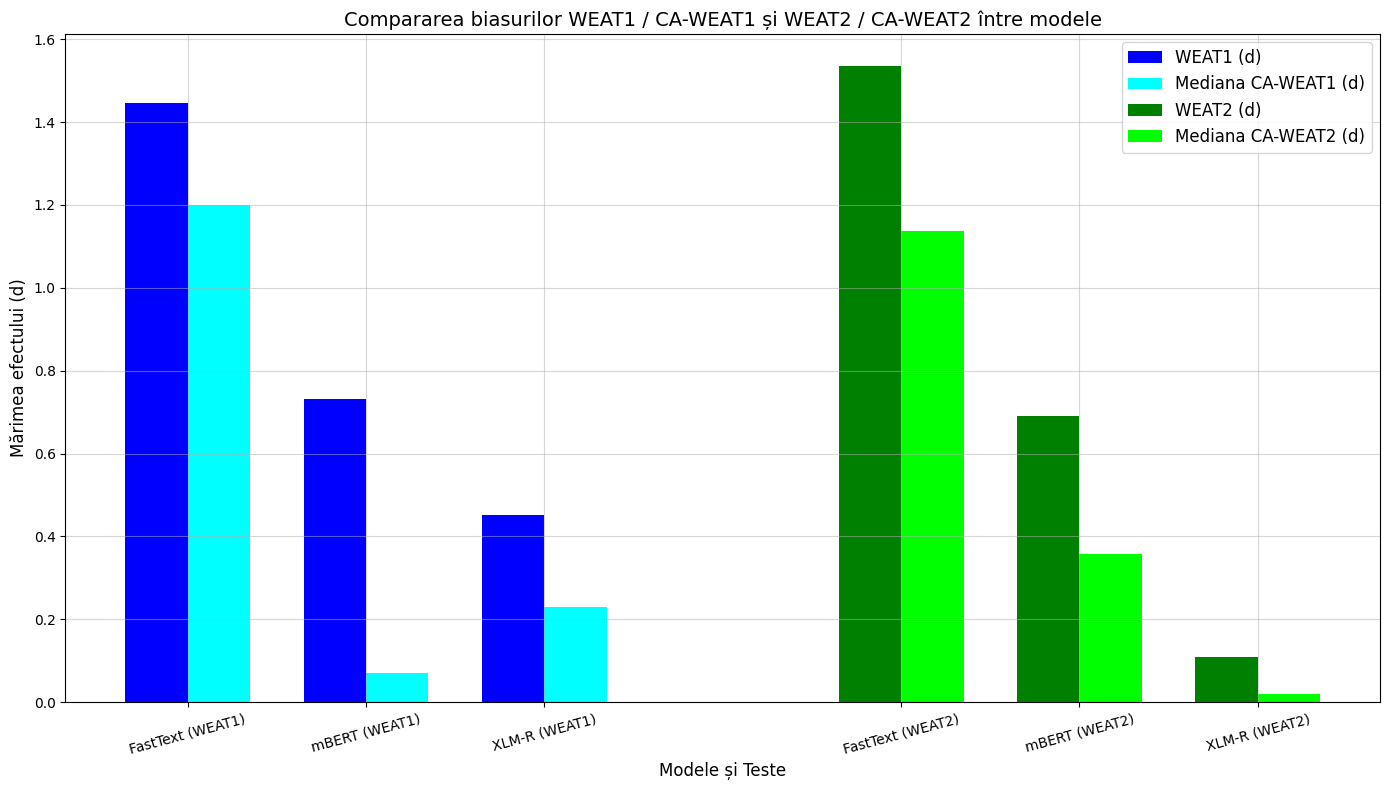

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Datele pentru WEAT1 și WEAT2
models = ["FastText", "mBERT", "XLM-R"]
effect_sizes_weat1 = [
    effect_size_weat1_fasttext,
    effect_size_weat1_mbert,
    effect_size_weat1_xlmr
]
effect_sizes_weat2 = [
    effect_size_weat2_fasttext,
    effect_size_weat2_mbert,
    effect_size_weat2_xlmr
]
medians_ca_weat1 = [
    median_d_ca_weat1_fasttext,
    median_d_ca_weat1_mbert,
    median_d_ca_weat1_xlmr
]
medians_ca_weat2 = [
    median_d_ca_weat2_fasttext,
    median_d_ca_weat2_mbert,
    median_d_ca_weat2_xlmr
]

# Crearea figurii
plt.figure(figsize=(14, 8))

# Configurare x
x = np.arange(len(models))  # Index pentru fiecare model
width = 0.35  # Lățimea barelor

# Plot pentru WEAT1
plt.bar(x - width/2, effect_sizes_weat1, width, label='WEAT1 (d)', color='blue')
plt.bar(x + width/2, medians_ca_weat1, width, label='Mediana CA-WEAT1 (d)', color='cyan')

# Plot pentru WEAT2 (mutare cu o distanță adițională)
x_weat2 = x + len(models) + 1  # Mutare pe axa x pentru WEAT2
plt.bar(x_weat2 - width/2, effect_sizes_weat2, width, label='WEAT2 (d)', color='green')
plt.bar(x_weat2 + width/2, medians_ca_weat2, width, label='Mediana CA-WEAT2 (d)', color='lime')

# Configurare axă și etichete
plt.xlabel("Modele și Teste", fontsize=12)
plt.ylabel("Mărimea efectului (d)", fontsize=12)
plt.title("Compararea biasurilor WEAT1 / CA-WEAT1 și WEAT2 / CA-WEAT2 între modele", fontsize=14)

# Setare etichete pentru axa x
x_ticks = np.concatenate([x, x_weat2])
x_labels = ["FastText (WEAT1)", "mBERT (WEAT1)", "XLM-R (WEAT1)",
            "FastText (WEAT2)", "mBERT (WEAT2)", "XLM-R (WEAT2)"]
plt.xticks(x_ticks, x_labels, fontsize=10, rotation=15)

plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Afișarea graficului
plt.tight_layout()
plt.show()


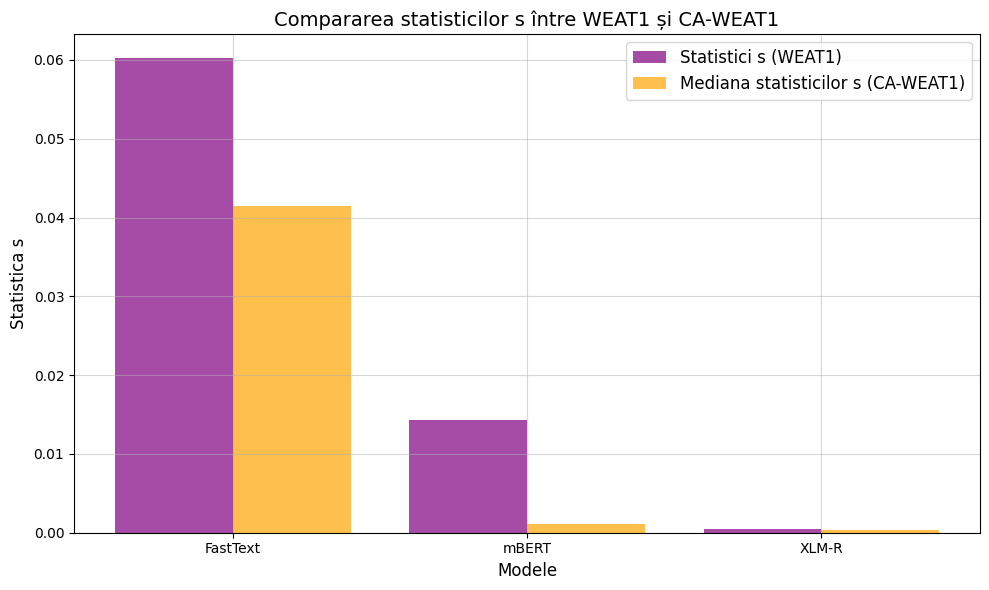

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Datele pentru statisticile \(s\) pentru WEAT1 și medianele pentru CA-WEAT1
models = ["FastText", "mBERT", "XLM-R"]
statistics_s_weat1 = [
    statistic_s_weat1_fasttext,
    statistic_s_weat1_mbert,
    statistic_s_weat1_xlmr
]
medians_s_ca_weat1 = [
    median_s_ca_weat1_fasttext,
    median_s_ca_weat1_mbert,
    median_s_ca_weat1_xlmr
]

# Crearea figurii
plt.figure(figsize=(10, 6))

# Bar chart pentru statisticile \(s\) din WEAT1 și CA-WEAT1
x = np.arange(len(models))  # Index pentru fiecare model
width = 0.4  # Lățimea barelor

# Plot pentru statisticile \(s\) din WEAT1
plt.bar(x - width/2, statistics_s_weat1, width, color='purple', alpha=0.7, label='Statistici s (WEAT1)')

# Plot pentru medianele statisticilor \(s\) din CA-WEAT1
plt.bar(x + width/2, medians_s_ca_weat1, width, color='orange', alpha=0.7, label='Mediana statisticilor s (CA-WEAT1)')

# Configurare axă și etichete
plt.xlabel("Modele", fontsize=12)
plt.ylabel("Statistica s", fontsize=12)
plt.title("Compararea statisticilor s între WEAT1 și CA-WEAT1", fontsize=14)
plt.xticks(x, models, fontsize=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Afișarea graficului
plt.tight_layout()
plt.show()


**Ce înseamnă o valoare mai mare a statisticii s?**  


**1. Asociere mai puternică:**
O valoare mare a statisticii s indică faptul că diferența de asociere dintre categoriile țintă este mai pronunțată.
De exemplu, „florile” sunt mult mai asociate cu „plăcut” decât „insectele”.  
**2. Bias mai evident:**
O valoare mare sugerează că modelul prezintă un bias semantic clar pentru categoriile țintă.
Acest bias poate fi influențat de datele pe care modelul a fost antrenat.

**Ce înseamnă o valoare mai mică a statisticii s?**   

**1. Asociere mai echilibrată:** O valoare mică a statisticii 𝑠 sugerează că diferența de asociere între categoriile țintă este redusă.
De exemplu, „florile” și „insectele” sunt asociate într-un mod similar cu „plăcut” și „neplăcut”.  
**2. Atenuarea biasului:**
Modelele multilingve (e.g., mBERT, XLM-R) tind să aibă valori mai mici ale statisticii s, ceea ce indică faptul că biasurile culturale sunt mai atenuate în comparație cu modelele monolingve (e.g., FastText).

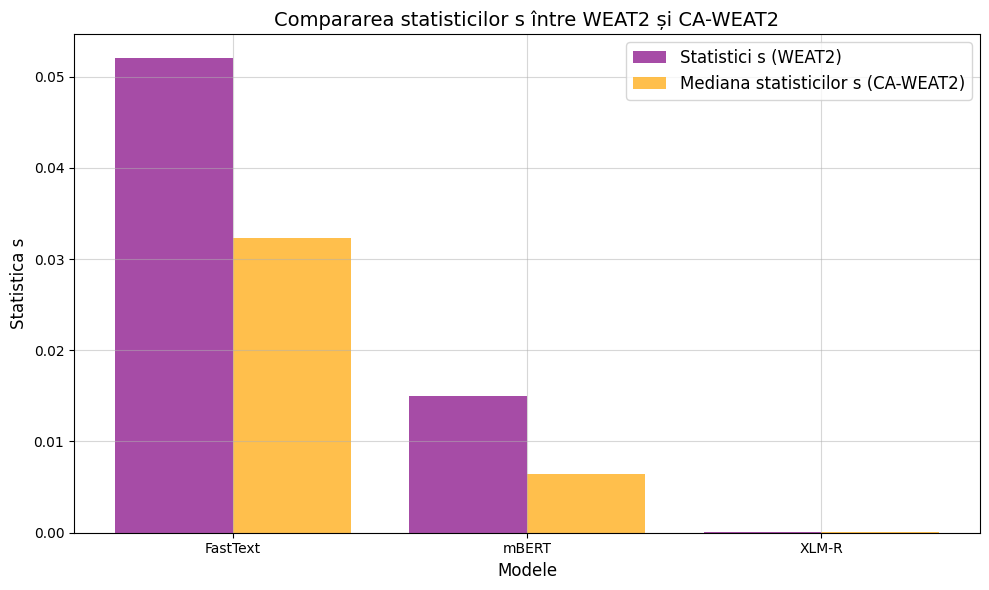

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Datele pentru statisticile \(s\) pentru WEAT1 și medianele pentru CA-WEAT1
models = ["FastText", "mBERT", "XLM-R"]
statistics_s_weat1 = [
    statistic_s_weat2_fasttext,
    statistic_s_weat2_mbert,
    statistic_s_weat2_xlmr
]
medians_s_ca_weat1 = [
    median_s_ca_weat2_fasttext,
    median_s_ca_weat2_mbert,
    median_s_ca_weat2_xlmr
]

# Crearea figurii
plt.figure(figsize=(10, 6))

# Bar chart pentru statisticile \(s\) din WEAT1 și CA-WEAT1
x = np.arange(len(models))  # Index pentru fiecare model
width = 0.4  # Lățimea barelor

# Plot pentru statisticile \(s\) din WEAT1
plt.bar(x - width/2, statistics_s_weat1, width, color='purple', alpha=0.7, label='Statistici s (WEAT2)')

# Plot pentru medianele statisticilor \(s\) din CA-WEAT1
plt.bar(x + width/2, medians_s_ca_weat1, width, color='orange', alpha=0.7, label='Mediana statisticilor s (CA-WEAT2)')

# Configurare axă și etichete
plt.xlabel("Modele", fontsize=12)
plt.ylabel("Statistica s", fontsize=12)
plt.title("Compararea statisticilor s între WEAT2 și CA-WEAT2", fontsize=14)
plt.xticks(x, models, fontsize=10)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Afișarea graficului
plt.tight_layout()
plt.show()
